In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Face Expression Recognition

* La primera parte de este proyecto busca clasificar emociones en imágenes de rostros mediante el uso de una red neuronal convolucional. A primera vista, esto parece sencillo. Utilizamos el dataset FER2013, que contiene imágenes de rostros en escala de grises con una resolución de 48x48 píxeles y clasifica en 7 emociones diferentes: $(0=Anger,~1=Disgust,~2=Fear,~3=Happiness,~4=Neutral,~5=Sadness,~6=Surprise)$. Sin embargo, al revisar el estado del arte en este problema, encontramos que el dataset FER2013 es particularmente desafiante. Las imágenes de baja resolución y la sutileza de las expresiones emocionales hacen que incluso los humanos logren una precisión promedio del 60%. Además, los artículos revisados reportan que la precisión más alta obtenida con este dataset es cercana al 77%.

* Primero, exploraremos qué hace que este dataset sea tan desafiante. Para ello, visualizaremos algunas imágenes y evaluaremos la dificultad de clasificarlas. Luego, entrenaremos una red neuronal convolucional simple para clasificar las emociones y evaluaremos su desempeño. Posteriormente, buscaremos mejorar la precisión utilizando técnicas avanzadas como el aprendizaje por transferencia (transfer learning) y mecanismos de atención.

![FER2013](https://imgur.com/GUHApSv.png)

# 1. Data Analysis

* Comenzamos explorando los datos del dataset FER2013. Primero, cargamos las imágenes y visualizamos algunas de ellas según su etiqueta.

* Aplicamos técnicas de reducción de dimensionalidad para visualizar las imágenes en un espacio de menor dimensión y evaluar si las emociones pueden separarse en este espacio. Para esto, utilizamos PCA y UMAP.

* Finalmente, visualizamos la distribución de las emociones en el dataset para identificar si existe un desbalance en las clases.

In [1]:
# Cargamos los paquetes necesarios primero para el manejo de los datos
import os
import seaborn as sns
import numpy as np
import pandas as pd
import umap.umap_ as umap
import plotly.express as px
from skimage import feature
from matplotlib import pyplot as plt
from matplotlib.image import imread
from matplotlib.ticker import AutoMinorLocator
from sklearn.decomposition import PCA

* El dataset viene en dos formas distintas, en archivo .csv o las imagenes en .jpg. En este caso vamos a usar el archivo .csv

In [2]:
# Sabemos que las imágenes vienen de este tamaño
img_height = 48
img_width = 48

* Veamos como se ve este .csv

In [8]:
# Leemos el archivo .csv con las imágenes
df = pd.read_csv("/content/drive/MyDrive/Presentacion/Dataset/fer2013.csv")
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


* Según la descripción del dataset las emociones se corresponen con el One-Hot encoding de: ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [ ]:
train_data = df[df['Usage'] == 'Training']
val_data = df[df['Usage'] == 'PublicTest']
test_data = df[df['Usage'] == 'PrivateTest']

* Vemos que los datos se dividen en emoción, pixels y en uso. En estos datos ya tenemos separados entrenamiento, validación que sería PublicTest y test que sería PrivateTest.

In [ ]:
print(f"Hay {train_data.shape[0]} imágenes para entrenamiento")
print(f"Hay {val_data.shape[0]} imágenes para validación")
print(f"Hay {test_data.shape[0]} imágenes para test")

Hay 28709 imágenes para entrenamiento
Hay 3589 imágenes para validación
Hay 3589 imágenes para test


* Para no tener que cargar el dataframe cada vez, pasamos los datos a formato .npy (pickle hubiese sido mejor) que comprime el tamaño y además los guardo las imágenes en tamaño (48,48,1) o sea imagen en escala de grises y a los labels en one hot encoding.

In [6]:
def saveData(dataframe, name : str):
    N = dataframe.shape[0]
    X = np.zeros((N, img_height, img_width, 1))
    y = np.zeros(N)
    for i in range(N):
        x = np.array(list(map(np.float32, dataframe.iloc[i]['pixels'].split()))).reshape((img_height,img_width, 1))
        yy = np.float32(dataframe.iloc[i]['emotion'])
        X[i] = x
        y[i] = yy

    y = pd.get_dummies(y)

    np.save(f'/content/drive/MyDrive/Presentacion/Dataset/{name}_X', X)
    np.save(f'/content/drive/MyDrive/Presentacion/Dataset/{name}_y', y)

In [ ]:
saveData(train_data, "train")
saveData(val_data, "val")
saveData(test_data, "test")

In [36]:
# Cargamos los datos ya separados en entrada y labels de la red
X_train = np.load("/content/drive/MyDrive/Presentacion/Dataset/train_X.npy")
y_train = np.load("/content/drive/MyDrive/Presentacion/Dataset/train_y.npy")

X_val = np.load("/content/drive/MyDrive/Presentacion/Dataset/val_X.npy")
y_val = np.load("/content/drive/MyDrive/Presentacion/Dataset/val_y.npy")

X_test = np.load("/content/drive/MyDrive/Presentacion/Dataset/test_X.npy")
y_test = np.load("/content/drive/MyDrive/Presentacion/Dataset/test_y.npy")

In [4]:
labels_emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
num_classes = len(labels_emotions)

* Veamos como se ven algunas imágenes

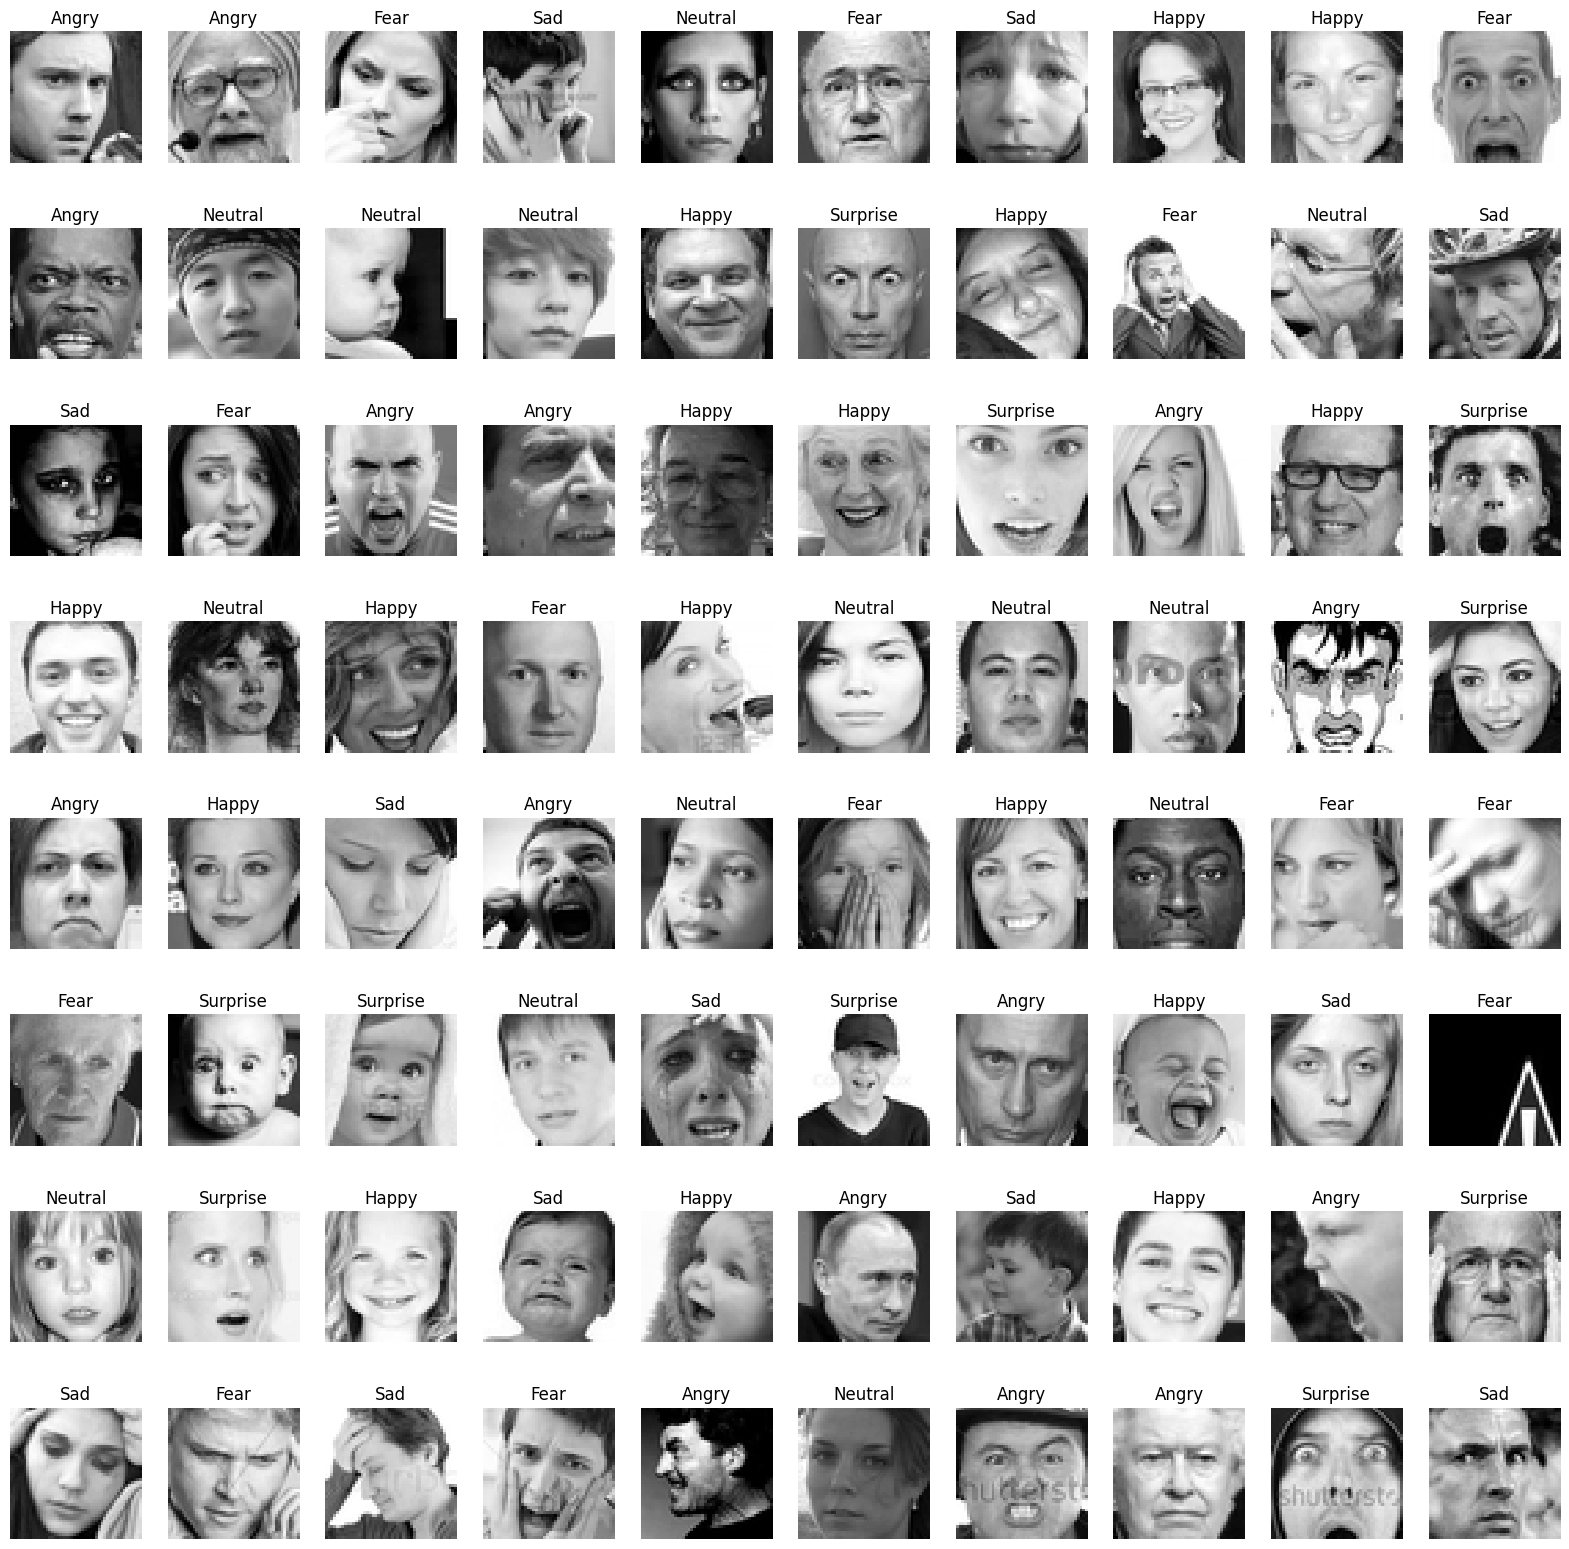

In [5]:
fig, ax = plt.subplots(8, 10, figsize=(20, 20))
ax = ax.ravel()

for i in range(len(ax)):
    ax[i].imshow(X_train[i], interpolation='none', cmap='gray')
    ax[i].set_title(labels_emotions[np.argmax(y_train[i])])
    ax[i].axis('off')
plt.show()

* Ya nos damos cuenta de que primero, las imágenes son de baja resolución, no todas las caras están centradas o son de personas, las emociones son difíciles de distinguir incluso para un ser humano, hay imágenes que no tienen sentido, por ejemplo una totalmente negra.

* Veamos el balance del dataset

In [9]:
print(f"Tenemos {num_classes} emociones que son: {labels_emotions}")
print("En todo el dataset tenemos: ")

for i in range(num_classes):
    print(f"Clase {labels_emotions[i]} tiene {df[df['emotion'] == i].shape[0]} imágenes")

Tenemos 7 emociones que son: ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
En todo el dataset tenemos: 
Clase Angry tiene 4953 imágenes
Clase Disgust tiene 547 imágenes
Clase Fear tiene 5121 imágenes
Clase Happy tiene 8989 imágenes
Clase Sad tiene 6077 imágenes
Clase Surprise tiene 4002 imágenes
Clase Neutral tiene 6198 imágenes


* Veamos las distribuciones en los sets de entrenamiento, validación.

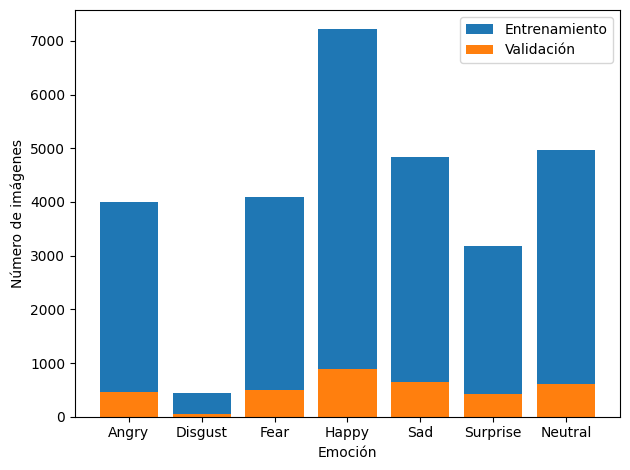

In [ ]:
train_dist = np.sum(y_train, axis=0)
val_dist = np.sum(y_val, axis=0)

plt.bar(labels_emotions, train_dist, label = 'Entrenamiento')
plt.bar(labels_emotions, val_dist, label = 'Validación')
plt.ylabel('Número de imágenes')
plt.xlabel('Emoción')
plt.legend()
plt.tight_layout()
plt.show()

* Vemos que es un dataset desblalanceado por lo que vamos a tener que tener cuidado con los resultados de los modelos que utilicemos porque podrían ser engañosos

## Limpieza de imágenes

* Vimos que unas de las imágenes es totalmente negra, por lo que vamos a eliminar imágenes dependiendo del promedio de intensidad de los píxeles, es decir si el promedio de intensidad de los píxeles es menor a un cierto umbral, eliminamos la imagen, lo mismo si el promedio de intensidad de los píxeles es mayor a un cierto umbral.

In [10]:
def clean_data(X, y, up_threshold = 200, low_threshold = 50):
    X_clean = []
    y_clean = []
    for i in range(len(X)):
        if np.mean(X[i]) > low_threshold and np.mean(X[i]) < up_threshold:
            X_clean.append(X[i])
            y_clean.append(y[i])
    return np.array(X_clean), np.array(y_clean)

In [11]:
X_train_cl, y_train_cl = clean_data(X_train, y_train)
X_val_cl, y_val_cl = clean_data(X_val, y_val)

In [12]:
print(f"Terminamos borrando {X_train.shape[0] - X_train_cl.shape[0]} imágenes de entrenamiento")
print(f"Terminamos borrando {X_val.shape[0] - X_val_cl.shape[0]} imágenes de validación")

Terminamos borrando 647 imágenes de entrenamiento
Terminamos borrando 78 imágenes de validación


## Reducción de dimensionalidad

* Para ver si podemos primero pre procesar los datos para luego utilizarlos en una red neuronal, vamos a utilizar PCA y UMAP para reducir la dimensionalidad de las imágenes y ver si las emociones se pueden separar en un espacio de mucho menor dimensión. Esto podría servirnos para utilizar un modelo sencillo para clasisficar las emociones.

In [21]:
# Probamos primero con PCA

def flattened_images(X):
    return np.array([img.reshape(img_height, img_width).flatten() for img in X])

pca_data = flattened_images(X_train_cl)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_data)

pca_df = pd.DataFrame(pca_result, columns=['pca1', 'pca2'])
pca_df['label'] = [labels_emotions[np.argmax(label)] for label in y_train_cl]

fig = px.scatter(pca_df, x='pca1', y='pca2', color='label', title='Reducción de dimensionalidad usando PCA')
fig.update_layout(width=800, height=600)
fig.show()

* Es probable que sea imposible separar las emociones en un espacio de tan baja dimensión, puesto que quizás no obtenemos suficiente varianza explicada acumulada con las primeras componentes principales.

* Probamos ahora con UMAP

In [25]:
from sklearn.preprocessing import StandardScaler

# Ahora probemos con UMAP
reducer = umap.UMAP(n_components=2, low_memory=True, n_neighbors=25, min_dist=0)

data_umap = np.array([img.reshape(img_height, img_width).flatten() for img in X_val_cl])

data_umap = StandardScaler().fit_transform(data_umap)

embedding = reducer.fit_transform(data_umap)

* Se intentó con muchos más parámetros de n_neighbors y min_dist pero no se logró separar las emociones en un espacio de menor dimensión.

In [26]:
# Creamos un dataframe con los datos reducidos
y_umap = np.argmax(y_val_cl, axis = 1).reshape(-1, 1)
df_umap = pd.DataFrame(np.hstack((embedding, y_umap)), columns=['x', 'y', 'label'])

# Graficamos
fig = px.scatter(df_umap, x='x', y='y', color='label', title='Reducción de dimensionalidad UMAP')
fig.update_layout(width=800, height=600)
fig.show()

* Claramente la separación se hace muy complicada para tan bajas dimensiones. Aun así se podría haber probado con un modelo de regresión logística multiclase para ver si se podía clasificar las emociones en espacios reducidos de dimensiones más altas que 2.

# Modelo 1 - CNN

* Comenzamos con un modelo simple de red neuronal convolucional los cuales está demostrado que tienen grandes capacidades para la clasificación de imágenes. En este caso vamos a utilizar un modelo muy simple con 3 capas convolucionales y 2 capas densas.

In [11]:
# Importamos los paquetes necesarios
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras import optimizers
from keras import Model
from keras import callbacks
from sklearn.metrics import confusion_matrix, classification_report

* Antes de pasar a la red tenemos que transformar los datos para que puedan ser utilizados en tensorflow. Donde pasamos cada X e y como input y output de un dataset de tensorflow. Tenemos además que preparar cada dataset, es decir, normalizar los datos, dividir en batchs y mezclar los datos. Además vamos a utilizar técnicas de aumento de datos para poder tener más datos y un modelo más robusto.

* El pre-procesamiento que hacemos es el siguiente:
    * Reescalamos los píxeles de [0,255] a [0,1]
    * Hacemos aumento de datos con: rotación de pocos grados, random flip horizontal, traslación random de pocos píxeles y crop random de la imagen.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
# Función que me devuelve un dataset de tensorflow a partir de inputs y labels
def prepare_dataset(X, y, batch_size = 64, shuffle = False, augmentation = False, training = False):

    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype=tf.float32)

    input = tf.data.Dataset.from_tensor_slices(X_tensor)
    labels = tf.data.Dataset.from_tensor_slices(y_tensor)

    if shuffle:
        dataset = tf.data.Dataset.zip((input, labels)).shuffle(buffer_size=30000).batch(batch_size)
    else:
        dataset = tf.data.Dataset.zip((input, labels)).batch(batch_size)

    # Aumento y preprocesamiento de datos
    data_preprocess = tf.keras.Sequential([layers.Rescaling(1./255)])
    
    data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal"),
                                                 layers.RandomRotation(0.1),
                                                 layers.RandomCrop(48, 48),
                                                 layers.RandomTranslation(0.1, 0.1)])

    # Le hacemos el pre procesamiento a los datos
    dataset = dataset.map(lambda x, y: (data_preprocess(x, training = training), y), num_parallel_calls=AUTOTUNE)

    if augmentation:
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training = training), y), num_parallel_calls=AUTOTUNE)

    return dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Definimos el tamaño de batch
batch_size = 64

# Cargamos los datos en los datasets
train_ds = prepare_dataset(X_train_cl, y_train_cl, batch_size, shuffle=True, augmentation=True, training=True)
val_ds = prepare_dataset(X_val_cl, y_val_cl, batch_size, shuffle=False, augmentation=False, training=False)
test_ds = prepare_dataset(X_test, y_test, batch_size, shuffle=False, augmentation=False, training=False)

* Veamos como se ve el aumento de datos que hicimos en las imágenes.

In [ ]:
data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal"),
                                                layers.RandomRotation(0.1),
                                                layers.RandomCrop(48, 48),
                                                layers.RandomTranslation(0.1, 0.1)])

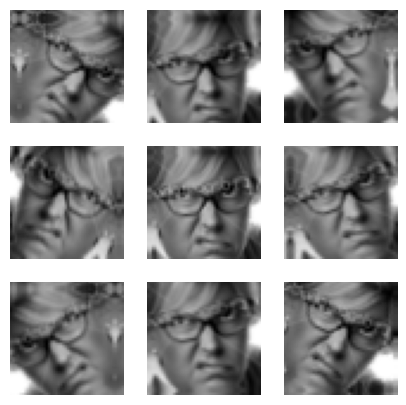

In [ ]:
plt.figure(figsize=(5, 5))
for images, labels in test_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0,:,:].numpy(), cmap='gray')
    plt.axis("off")

### Pesos de clases
* Como ya tenemos los datos cargados hay algo que tenemos que hacer antes y es lidiar con el desbalance de clases, para esto vamos a utilizar pesos de clases en la función de costo de la red neuronal convolucional, de esta forma le daremos más importancia a las clases minoritarias.

In [ ]:
# Función que calcula el diccionario de pesos de las clases
def get_weights(y):
    dist = np.sum(y, axis = 0)
    total = np.sum(dist)
    weights = np.float32([total / (l * num_classes) for l in dist])
    return {i : w for i, w in enumerate(weights)}

In [ ]:
class_weights = get_weights(y_train_cl)
class_weights

{0: 1.0255455,
 1: 9.410462,
 2: 0.9982214,
 3: 0.5672643,
 4: 0.85222304,
 5: 1.3139486,
 6: 0.8199749}

**Al final no los termino usando porque empeoran el entrenamiento**

* Creamos el primer modelo de
CNN que vamos a utilizar, este va a ser un modelo pequeño con pocas capas convolutionales y una capa densa a la salida de la red convolucional.

* En esta red añadimos capas de *batch normalization* que normalizan las activaciones de la red para que tengan media 0 y varianza 1, esto ayuda a que la red converja más rápido y a que no se saturen las activaciones. Además añadimos capas de *dropout* para regularizar la red y evitar el overfitting. También usamos capas de *max pooling* para reducir la dimensionalidad.

* Usamos además la función de activación elu que se define como $elu(x) = x$ si $x>0$ y $elu(x) = \alpha (e^x-1)$ si $x<=0$ donde $\alpha$ es un hiperparámetro que se puede ajustar, como no se lo estamos poniendo por default toma 1.

* También se usa la inicialización de peso He que se define como $He = \sqrt{\frac{2}{n_{in}}}$ donde $n_{in}$ es el número de neuronas de entrada a la capa.

In [ ]:
# Modelo pequeño de CNN

# Input de las imágenes
input_img = layers.Input(shape=(img_height, img_width, 1), name='imagenes')

# Capa convolucional 1
x = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal', activation='elu')(input_img)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

# Capa convolucional 2
x = layers.Conv2D(32, 3, padding='same', kernel_initializer='he_normal', activation='elu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

# Capa convolucional 3
x = layers.Conv2D(16, 3, padding='same', kernel_initializer='he_normal', activation='elu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

# Output de la CNN
cnn_output = layers.Flatten()(x)

# Capa fully connected 1
fc1 = layers.Dense(512, kernel_initializer='he_normal', activation='elu')(cnn_output)
x = layers.BatchNormalization()(fc1)
x = layers.Dropout(0.5)(x)

# Output de la red
output = layers.Dense(num_classes, activation='softmax')(x)

In [ ]:
model_mini = Model(inputs=input_img, outputs=output)
model_mini.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 imagenes (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        18464     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 32)        128   

* Este modelo termina con 323.991 parámetros entrenables. Para entrenar el modelo utilizamos el optimizer Adam con un learning rate inicial de 0.001, la función de costo es la categorical crossentropy. El modelo en principio tiene como objetivo entrenarse durante 150 épocas.

In [ ]:
# Definimos métricas, optimizador y función de loss del modelo
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
]

# Optimizador
optimizer = optimizers.Adam(learning_rate=0.001)

# Función de loss
loss_func = tf.keras.losses.CategoricalCrossentropy()

# Número de épocas a entrenar
num_epochs = 150

* Antes de mandar a entrenar el modelo utilizamos callbacks para que el modelo: 
    - Se guarde en el mejor checkpoint de acuerdo a la función de costo en el set de validación.
    - Reduzca el learning rate si la función de costo en el set de validación no mejora por 5 épocas.
    - Pare el entrenamiento si la función de costo en el set de validación no mejora durante 20 épocas.

In [ ]:
# Definimos callbacks del modelo para guardar el mejor modelo y para parar el entrenamiento si no mejora
checkpoint = callbacks.ModelCheckpoint('/content/drive/MyDrive/Presentacion/Models/model_mini_FER.h5',
                                       monitor='val_loss',
                                       save_best_only=True,
                                       save_weights_only=True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                               fator = 0.1,
                                                               patience = 5,
                                                               min_lr = 1e-7,
                                                               verbose = 1)

early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta = 0.0001,
                                                  patience = 20,
                                                  verbose = 1,
                                                  restore_best_weights = True)

* Teniendo esto en cuenta compilamos y entrenamos el modelo

In [ ]:
# Compilamos el modelo
model_mini.compile(optimizer=optimizer,
                    loss=loss_func,
                    metrics=METRICS)

In [ ]:
# Entrenamos el modelo
history = model_mini.fit(train_ds,
                validation_data=val_ds,
                epochs=num_epochs,
                callbacks=[checkpoint, early_stopping, learning_rate_reduction])

Epoch 1/150
439/439 [==============================] - 12s 10ms/step - loss: 2.1715 - accuracy: 0.2439 - val_loss: 1.6481 - val_accuracy: 0.3475 - lr: 0.0010
Epoch 2/150
439/439 [==============================] - 4s 8ms/step - loss: 1.7335 - accuracy: 0.3254 - val_loss: 1.5301 - val_accuracy: 0.4218 - lr: 0.0010
Epoch 3/150
439/439 [==============================] - 4s 8ms/step - loss: 1.6180 - accuracy: 0.3641 - val_loss: 1.4827 - val_accuracy: 0.4318 - lr: 0.0010
Epoch 4/150
439/439 [==============================] - 4s 8ms/step - loss: 1.5522 - accuracy: 0.3971 - val_loss: 1.4503 - val_accuracy: 0.4452 - lr: 0.0010
Epoch 5/150
439/439 [==============================] - 3s 8ms/step - loss: 1.5076 - accuracy: 0.4126 - val_loss: 1.4562 - val_accuracy: 0.4446 - lr: 0.0010
Epoch 6/150
439/439 [==============================] - 4s 8ms/step - loss: 1.4720 - accuracy: 0.4316 - val_loss: 1.4137 - val_accuracy: 0.4560 - lr: 0.0010
Epoch 7/150
439/439 [==============================] - 4s 8ms/

* Vemos que luego de 51 épocas ocurre un early stopping porque el loss de validación no mejoró con respecto a las 20 épocas anteriores. Veamos como fue la evolución del loss de entreanmiento y validación.

In [ ]:
model_mini.save('/content/drive/MyDrive/Presentacion/Models/model_mini.keras')
model_mini.save('/content/drive/MyDrive/Presentacion/Models/model_mini.H5')

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/MyDrive/Presentacion/Models/history_mini.csv', index=False)

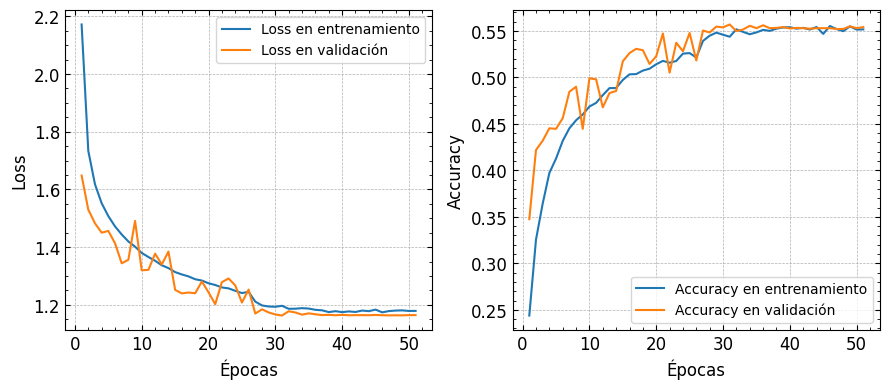

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

epocas_range = range(1, len(history.history['accuracy'])+1)

ax[0].plot(epocas_range,history.history['loss'], label='Loss en entrenamiento')
ax[0].plot(epocas_range,history.history['val_loss'], label='Loss en validación')
ax[0].set_xlabel('Épocas', fontsize = 12)
ax[0].set_ylabel('Loss', fontsize = 12)
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_major_locator(plt.AutoLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_ticks_position('both')
ax[0].xaxis.set_ticks_position('both')
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[0].legend(fontsize=10, loc = "best")
ax[0].grid(linestyle='--', linewidth=0.5)

ax[1].plot(epocas_range,history.history['accuracy'], label='Accuracy en entrenamiento')
ax[1].plot(epocas_range,history.history['val_accuracy'], label='Accuracy en validación')
ax[1].set_xlabel('Épocas', fontsize = 12)
ax[1].set_ylabel('Accuracy', fontsize = 12)
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_major_locator(plt.AutoLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_ticks_position('both')
ax[1].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[1].legend(fontsize=10, loc = "best")
ax[1].grid(linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

* Vemos que el modelo no está sobreajustando, pero que estamos estancados en un mínimo donde el loss de validación ni el de entrenamiento mejoran. Esto puede ser debido a que el modelo es muy simple y no puede capturar la complejidad de los datos.

* Si evaluamos en el set de test vemos que obtenemos un accuracy de 0.56 lo cual es bajo.

In [ ]:
loss_test, acc_test = model_mini.evaluate(test_ds)
print(f'Loss en test: {loss_test}')
print(f'Accuracy en test: {acc_test}')

57/57 [==============================] - 0s 5ms/step - loss: 1.1213 - accuracy: 0.5637
Loss en test: 1.1212514638900757
Accuracy en test: 0.5636667609214783


* Una mejor forma de evaluar que tan bien está clasificando la red es ver la matriz de confusión y el reporte de clasificación aún en el set de entrenamiento.

In [ ]:
predicts = model_mini.predict(test_ds)

57/57 [==============================] - 0s 2ms/step


              precision    recall  f1-score   support

       Angry       0.40      0.52      0.45       491
     Disgust       0.45      0.09      0.15        55
        Fear       0.42      0.25      0.31       528
       Happy       0.79      0.83      0.81       879
         Sad       0.45      0.29      0.35       594
    Surprise       0.73      0.69      0.71       416
     Neutral       0.48      0.71      0.57       626

    accuracy                           0.56      3589
   macro avg       0.53      0.48      0.48      3589
weighted avg       0.56      0.56      0.55      3589



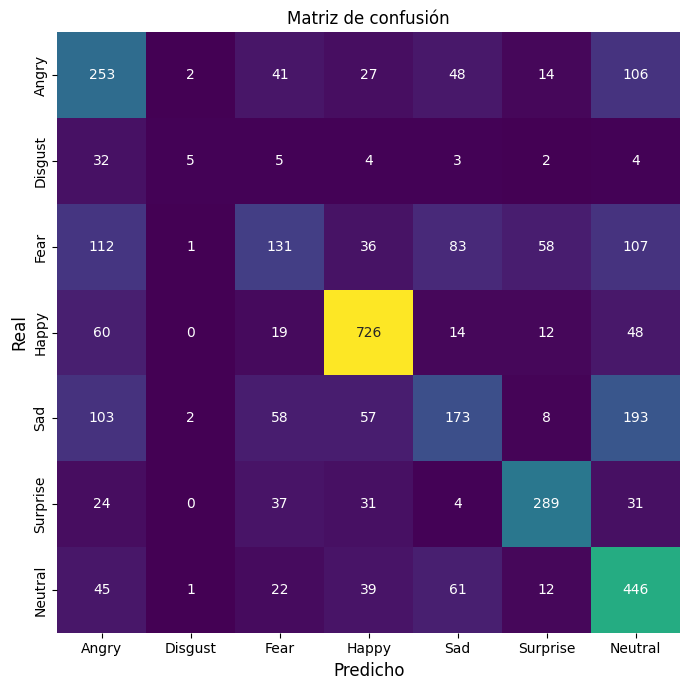

In [ ]:
y_pred = np.argmax(predicts, axis=1)
y_true = np.argmax(np.concatenate([y for _, y in test_ds], axis=0), axis = 1)

print(classification_report(y_true, y_pred, target_names=labels_emotions))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=labels_emotions, yticklabels=labels_emotions, cbar=False)
plt.xlabel('Predicho', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.title('Matriz de confusión', fontsize=12)
plt.tight_layout()
plt.show()

* Recordando:
    * Precisión: la precisión nos da la proporción de verdaderos positivos entre todos los positivos detectados. $\frac{TP}{TP+FP}$
    * Recall: nos da la proporción de verdaderos positivos entre todos los positivos que había. $\frac{TP}{TP+FN}$
    * F1-score: es la media armónica entre la precisión y el recall. $F1 = 2 \frac{precision \times recall}{precision+recall}$

- En este caso vemos que la red logra un alto rendimiento en las expresiones de _feliz_ y _sorpresa_, teniendo altas precisiones y recalls.

- En cambio, las expresiones de _disgusto_,  _miedo_ y _tristeza_ son las que peor clasifica la red, sobretodo por el bajo recall que nos indica que comete muchos falsos negativos.

- Por otro lado hay un rendimiento moderado en _enojado_ y _neutral_. 
    - En neutral ocurre que tiene una precisión baja pero un recall moderado, lo que nos indica que identifica muchas imágenes neutrales correctamente pero también muchos falsos positivos.

# Modelo 2 - Transfer Learning

* Vamos a hacer transfer learning utilizando un modelo preentrenado en el dataset ImageNet, en este caso vamos a utilizar el modelo VGG16 que es un modelo muy conocido y que ha demostrado tener un buen desempeño en la clasificación de imágenes.

In [ ]:
# Limpiamos la memoria de tensorflow
tf.keras.backend.clear_session()

train_ds = prepare_dataset(X_train_cl, y_train_cl, batch_size, shuffle=True, augmentation=True, training=True)
val_ds = prepare_dataset(X_val_cl, y_val_cl, batch_size, shuffle=False, augmentation=False, training=False)
test_ds = prepare_dataset(X_test, y_test, batch_size, shuffle=False, augmentation=False, training=False)

# Cargamos el modelo VGG16 desde tensorflow
preprocess_input = tf.keras.applications.vgg16.preprocess_input
vgg = tf.keras.applications.VGG16(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

* El modelo VGG16 consta de 13 bloques convolucionales y 3 capas densas, con un aproximado de 15 millones de parámetros. Vamos a utilizar la red pre-entrenada VGG16 para la clasificación de ImageNet, a esta le cambiamos las capas de salida para que se ajusten a nuestro problema de clasificación de emociones.

* Además vamos a hacer que las últimas 3 capas de la red sean entrenables o sea estamos entrenando casi 5 millones de parámetros

![VGG16](https://imgur.com/aHdmoHt.png)

In [ ]:
# Vamos a hacer que las últimas 3 capas de la red sean entrenables o sea estamos entrenando casi 5 millones de parámetros
for layer in vgg.layers[:-3]:
    layer.trainable = False
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
# Primero tenemos que tener una entrada si o si de 3 canales así que hacemos primero una convolucional de nuestras imágenes y luego lo pasamos a la red VGG

input_img = layers.Input(shape=(img_height, img_width, 1), name='imagenes')
x = layers.Conv2D(3,(3,3),padding='same')(input_img)

# Pre procesamiento de vgg y capa global average pooling para tener un output de 512
x = vgg(x)
x = global_average_layer(x)

# Agregamos la capa fully connected
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Output de la red
output = layers.Dense(num_classes, activation='softmax')(x)

# Creamos el modelo
modelVGG = Model(inputs=input_img, outputs=output)

modelVGG.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 imagenes (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 3)         30        
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                             

* Esta red se entrena muy parecida a la anterior (mismo con el resto de entrenadas en este notebook), con la diferencia de que en este caso se entrena por 50 épocas y se cambia el learning rate si no mejora por 10 épocas en vez de 5.

In [ ]:
# Definimos métricas, optimizador y función de loss del modelo
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
]

# Optimizador

optimizer = optimizers.Adam(learning_rate=0.01)

# Función de loss
loss_func = tf.keras.losses.CategoricalCrossentropy()

# Número de épocas a entrenar
num_epochs = 100

# Definimos callbacks del modelo para guardar el mejor modelo y para parar el entrenamiento si no mejora

checkpoint = callbacks.ModelCheckpoint('/content/drive/MyDrive/Presentacion/Models/VGG16_FER.h5',
                                       monitor='val_loss',
                                       save_best_only=True,
                                       save_weights_only=True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                               fator = 0.1,
                                                               patience = 10,
                                                               min_lr = 1e-7,
                                                               verbose = 1)

early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta = 0.0001,
                                                  patience = 20,
                                                  verbose = 1,
                                                  restore_best_weights = True)

In [ ]:
# Compilamos el modelo
modelVGG.compile(loss=loss_func,
              optimizer=optimizer,
              metrics=METRICS)

In [ ]:
# Entrenamos el modelo
historyVGG = modelVGG.fit(train_ds,
                validation_data=val_ds,
                epochs=num_epochs,
                callbacks=[checkpoint, early_stopping, learning_rate_reduction])

Epoch 1/100
439/439 [==============================] - 10s 21ms/step - loss: 1.8334 - accuracy: 0.2472 - val_loss: 1.8121 - val_accuracy: 0.2518 - lr: 0.0100
Epoch 2/100
439/439 [==============================] - 8s 18ms/step - loss: 1.8104 - accuracy: 0.2518 - val_loss: 1.8109 - val_accuracy: 0.2518 - lr: 0.0100
Epoch 3/100
439/439 [==============================] - 8s 18ms/step - loss: 1.8096 - accuracy: 0.2518 - val_loss: 1.8109 - val_accuracy: 0.2518 - lr: 0.0100
Epoch 4/100
439/439 [==============================] - 8s 18ms/step - loss: 1.8096 - accuracy: 0.2518 - val_loss: 1.8091 - val_accuracy: 0.2518 - lr: 0.0100
Epoch 5/100
439/439 [==============================] - 8s 18ms/step - loss: 1.8095 - accuracy: 0.2518 - val_loss: 1.8091 - val_accuracy: 0.2518 - lr: 0.0100
Epoch 6/100
439/439 [==============================] - 8s 17ms/step - loss: 1.8093 - accuracy: 0.2518 - val_loss: 1.8094 - val_accuracy: 0.2518 - lr: 0.0100
Epoch 7/100
439/439 [==============================] - 8s

* Vemos que el modelo detiene el entrenamiento en la época 24.

* Parece que el modelo no es el adecuado para este tipo de problema ya que no estamos consiguiendo aumentar la precisión del modelo a medida que pasan las épocas. En un principio pensé que podría ser cosa de las capas de entrada que no coinciden. Habría que probar con alguna forma que importe las imágenes en tipo RGB

In [ ]:
modelVGG.save('/content/drive/MyDrive/Presentacion/Models/modelVGG.H5')
historyVGG_df = pd.DataFrame(historyVGG.history)
historyVGG_df.to_csv('/content/drive/MyDrive/Presentacion/Models/historyVGG.csv', index=False)

* Veamos el loss y accuracy en el set de entrenamiento y validación en función de las épocas

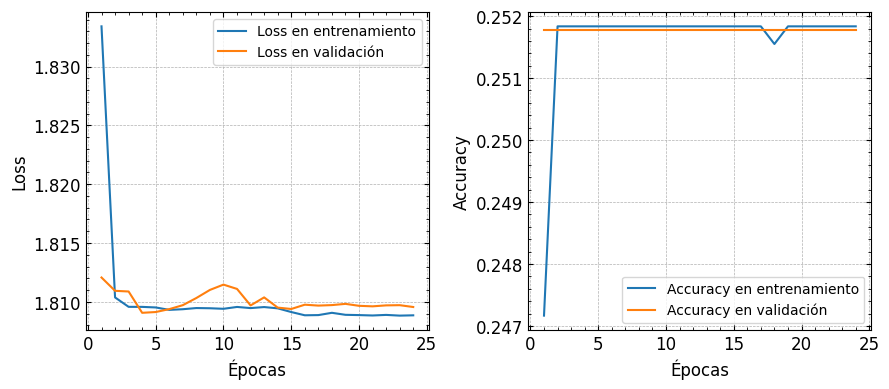

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

epocas_range = range(1, len(historyVGG_df['accuracy'])+1)

ax[0].plot(epocas_range,historyVGG_df['loss'], label='Loss en entrenamiento')
ax[0].plot(epocas_range,historyVGG_df['val_loss'], label='Loss en validación')
ax[0].set_xlabel('Épocas', fontsize = 12)
ax[0].set_ylabel('Loss', fontsize = 12)
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_major_locator(plt.AutoLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_ticks_position('both')
ax[0].xaxis.set_ticks_position('both')
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[0].legend(fontsize=10, loc = "best")
ax[0].grid(linestyle='--', linewidth=0.5)

ax[1].plot(epocas_range,historyVGG_df['accuracy'], label='Accuracy en entrenamiento')
ax[1].plot(epocas_range,historyVGG_df['val_accuracy'], label='Accuracy en validación')
ax[1].set_xlabel('Épocas', fontsize = 12)
ax[1].set_ylabel('Accuracy', fontsize = 12)
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_major_locator(plt.AutoLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_ticks_position('both')
ax[1].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[1].legend(fontsize=10, loc = "best")
ax[1].grid(linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

* Vemos que permanece constante en un mínimo local, por lo que no estamos obteniendo un buen modelo por mas que sea de muchisimos parámetros.

In [ ]:
loss_test, acc_test = modelVGG.evaluate(test_ds)
print(f'Loss en test: {loss_test}')
print(f'Accuracy en test: {acc_test}')

57/57 [==============================] - 1s 14ms/step - loss: 1.8153 - accuracy: 0.2449
Loss en test: 1.815300703048706
Accuracy en test: 0.24491502344608307


* El accuracy en el set de test es de 0.25 lo cual sigue siendo muy malo comparado con el estado del arte. Tiene quizas sentido que no funcione un transfer learning de un modelo preentrenado en ImageNet para este problema ya que las características que aprende el modelo VGG16 en ImageNet no son las mismas que las que necesita para clasificar emociones en rostros. Sin embargo era una opción a probar dado que varias veces se ha demostrado que transfer learning de modelos preentrenados en ImageNet es una buena opción para problemas de clasificación de imágenes.

# Redes Neuronales Convolucionales con mecanismos de atención

* Vamos a utilizar mecanismos de atención para mejorar el desempeño de la red neuronal convolucional. Los mecanismos de atención son una forma de que la red pueda enfocarse en partes importantes de la imagen a la hora de clasificarla. En este caso vamos a utilizar un mecanismo de atención llamado Spatial Attention que permite esto

* Esto es importante en nuestro problema de clasificación de emoción en imágenes, ya que en una cara humana, la expresión de la emoción se encuentra en partes específicas de la cara, como los ojos o la boca. Por lo tanto, es importante que el modelo pueda enfocarse en estas partes específicas de la imagen para poder hacer una clasificación correcta.

## Modelo 3 - STN - Redes con transformaciones espaciales

* Las redes con trasnformaciones espaciales permiten aprender a la red a transformar las imágenes y los feature maps para poder hacer una buena clasificación, lo interesante de este modulo es que es diferenciable y puede integrarse tranquilamente en arquitecturas convolucionales existentes. Estas transformaciones que se aprenden incluyen traslación, escalado, rotación y deformaciones más complejas. Al incorporar STNs, los modelos pueden aprender a ser invariantes a diversas transformaciones espaciales, mejorando su robustez y rendimiento en diversas tareas.

![STN_block](https://imgur.com/N880vT2.png)

![STN_transform](https://imgur.com/aLyHtIL.png)

* El mecanismo STN se divide esencialmente en tres partes. En orden de ejecución:
    * Primero una red de localización toma el mapa de features de entrada, y a traves de varias capas ocultas produce los parámetros de la transformación espacial (parámetros como ángulos de rotaciones etc.) que se aplicará al mapa de features. 
    * Luego, los parámetros de esta transformación se utilizan para formar una grilla de muestreo que es el conjunto de puntos necesarios para producir la salida transformada. 
    * Finalmente el mapa de features y la grilla de muestreo se toman para producir el mapa de salida muestreado desde la entrada en los puntos de la grilla.

https://arxiv.org/abs/1506.02025 (Spatial Transformer Networks)

https://arxiv.org/abs/1902.01019 (Deep-Emotion: Facial Expression Recognition Using Attentional Convolutional Network)

### Local Binary Patterns

* Otro truco que vamos a utilizar es el de agregar features que se extraen de manera manual a la red neuronal, en este caso vamos a utilizar el histograma de la transformación LBP (Local Binary Patterns) que es una técnica muy utilizada en la detección de objetos en imágenes y que podría ser útil para la clasificación de emociones en este caso. Esto es algo que se utilizaba anterior al deep learning junto con SVMs para clasificar estas imágenes.

* LBP se basa en la comparación de un píxel con sus vecinos y asigna un valor binario a cada píxel dependiendo de si el vecino es mayor o menor que el píxel central. Luego se transforma este valor binario a un número decimal transformando la imagen permitiendo obtener detalles locales. Como features se utiliza el histograma de los LBP de la imagen.

![LBP](../EmotionalChatbot/images/LBP.jpeg)

In [ ]:
# LBP features
def get_features_LBP(data, npoints, radius):
    lbp_features = {}
    for label in data.keys():
        lbp_features[label] = []
        for img in data[label]:
            lbp = feature.local_binary_pattern(img, npoints, radius, method="uniform")
            lbp_features[label].append(lbp)
    return lbp_features

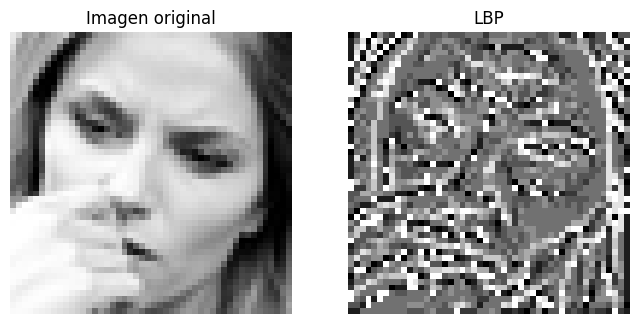

In [ ]:
img = X_train_cl[2].reshape((img_height, img_width))
lbp = feature.local_binary_pattern(img, 8, 1, method="uniform")

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Imagen original')
ax[0].axis('off')

ax[1].imshow(lbp, cmap='gray')
ax[1].set_title('LBP')
ax[1].axis('off')
plt.show()

In [ ]:
from stn import spatial_transformer_network as transformer
from skimage import feature

class LocalBinaryPatterns:
	def __init__(self, numPoints, radius):
		# Numero de vecinos y radio
		self.numPoints = numPoints
		self.radius = radius

	def describe(self, image, eps=1e-7):
		# Calcula el LBP de la imágen y luego el histograma de los patrones
		lbp = feature.local_binary_pattern(image, self.numPoints,
			self.radius, method="uniform")
		(hist, _) = np.histogram(lbp.ravel(),
			bins=np.arange(0, self.numPoints + 3),
			range=(0, self.numPoints + 2))
		# Normalizamos el histograma
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)

		return hist

In [ ]:
# Instanciamos el descriptor LBP con 8 vecinos y radio 1
descriptor = LocalBinaryPatterns(8, 1)
# Nos guardamos el tamaño que tendrá el historama que será nuestro vector de features
lbp_feature_size = descriptor.numPoints + 2

* Para hacer todo esto necesitamos un nuevo dataset de entrenamineto que contenga las imágenes y los features de LBP.

In [ ]:
# Funciones para crear las bases de datos
# Definimos una función que calcule los features LBP de un conjunto de imágenes
def compute_lbp_features(images):
    # En la entrada de la red necesitaremos un tensor de tamaño (batchsize, lbp_feature_size)
    lbp_features = tf.zeros((0, lbp_feature_size))
    for img in images:
        # Convertimos las imágenes a un array de numpy y las redimensionamos
        img_aux = img.numpy().reshape(img_height, img_width)

        # Calculamos los features LBP
        lbp = descriptor.describe(img_aux)

        # Convertimos los features a un tensor de tensorflow
        lbp_actual = tf.convert_to_tensor(lbp)

        # Concatenamos los features de la imagen actual a los features de todas las imágenes
        lbp_features = tf.concat([lbp_features, [lbp_actual]], axis=0)
    return lbp_features

# Definimos una función
def get_tensors_lbp(X, y, shuffle, batch_size=64):
    x = tf.convert_to_tensor(X)
    y = tf.convert_to_tensor(y)

    # Convertimos las imágenes a tensores de tensorflow
    x = tf.convert_to_tensor(x)

    # Calculamos los features LBP de las imágenes
    lbp = compute_lbp_features(x)

    # Creamos los dos inputs de la red desde los arrays de numpy
    input1 = tf.data.Dataset.from_tensor_slices(x)
    input2 = tf.data.Dataset.from_tensor_slices(lbp)

    # Creamos la entrada y salida final de la red
    input = tf.data.Dataset.zip((input1, input2)).map(lambda x1, x2: {'imagenes': x1, 'lbps': x2})
    output = tf.data.Dataset.from_tensor_slices(y)
    
    # Creamos el dataset final con las imágenes y las etiquetas
    if shuffle:
      dataset = tf.data.Dataset.zip((input, output)).shuffle(buffer_size=40000).batch(batch_size)
    else:
      dataset = tf.data.Dataset.zip((input, output)).batch(batch_size)

    return dataset

In [ ]:
# Nuevos datasets de tensorflow con los features LBP
train_ds_lbp = get_tensors_lbp(X_train_cl, y_train_cl, True)
val_ds_lbp = get_tensors_lbp(X_val_cl, y_val_cl, False)
test_ds_lbp = get_tensors_lbp(X_test, y_test, False)

In [ ]:
@keras.saving.register_keras_serializable()
class SpatialTransformLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(SpatialTransformLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return transformer(inputs[0], inputs[1])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

* Creamos el modelo con los dos inputs. El modelo es el que se utilizó en el paper de STN y se compone de 2 bloques convolucionales y el módulo STN, en este caso lo descompuse en la red de localización y la capa que contiene la grilla de muestreo. Luego de esto se concatenan los features de LBP y se pasan a una capa densa que se conecta a la capa de salida de la red.

* Algo que agregamos en este modelo es el uso de regularización L2 para evitar el overfitting.

In [ ]:
# Creamos el modelo de la red con el ínput de las imágenes, el spatial transformer y el input de las features LBP
# Input de las imágenes
input_img = layers.Input(shape=(img_height, img_width, 1), name='imagenes')

# Data augmentation
x_pre = layers.RandomFlip('horizontal')(input_img)
x_pre = layers.RandomRotation(0.1)(x_pre)
x_pre = layers.RandomCrop(48, 48)(x_pre)
x_pre = layers.RandomTranslation(0.1, 0.1)(x_pre)

# Pre procesamiento
x_pre = layers.Rescaling(1./255)(input_img)


# Bloque convolucional 1
x = layers.Conv2D(10, 3, padding='same', kernel_initializer='random_normal', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(),
                   bias_regularizer=tf.keras.regularizers.L2())(x_pre)
x = layers.Conv2D(10, 3, padding='same', kernel_initializer='random_normal')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.ReLU()(x)

# Bloque convolucional 2
x = layers.Conv2D(10, 3, padding='same', kernel_initializer='random_normal', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(),
                   bias_regularizer=tf.keras.regularizers.L2())(x)
x = layers.Conv2D(10, 3, padding='same', kernel_initializer='random_normal', kernel_regularizer=tf.keras.regularizers.L2(),
                   bias_regularizer=tf.keras.regularizers.L2())(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.5)(x)

# Red de localización esto devuelve el theta
loc_net_out = layers.Conv2D(8, 7, kernel_initializer='random_normal', padding='same', kernel_regularizer=tf.keras.regularizers.L2(),
                   bias_regularizer=tf.keras.regularizers.L2())(x_pre)
loc_net_out = layers.MaxPooling2D(4)(loc_net_out)
loc_net_out = layers.ReLU()(loc_net_out)

loc_net_out = layers.Conv2D(10, 5, kernel_initializer='random_normal', padding = 'same', kernel_regularizer=tf.keras.regularizers.L2(),
                   bias_regularizer=tf.keras.regularizers.L2())(loc_net_out)
loc_net_out = layers.MaxPooling2D(4)(loc_net_out)
loc_net_out = layers.ReLU()(loc_net_out)

loc_net_out = layers.Flatten()(loc_net_out)
loc_net_out = layers.Dense(32, kernel_initializer='random_normal', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(),
                   bias_regularizer=tf.keras.regularizers.L2())(loc_net_out)
theta = layers.Dense(6, kernel_initializer='zeros',bias_initializer=tf.keras.initializers.Constant([1,0,0,0,1,0]), activation='linear')(loc_net_out)

# Output de la CNN
cnn_output = SpatialTransformLayer()([x, theta])

cnn_output = layers.Flatten()(cnn_output)

# Input de los features LBP
lbp_input = layers.Input(shape=(lbp_feature_size,), name='lbps')

# Concatenamos las salidas de la CNN y los features LBP
concat = layers.Concatenate()([cnn_output, lbp_input])

# Capa fully connected 1
fc1 = layers.Dense(50, kernel_initializer='random_normal',
                   activation='relu',
                   kernel_regularizer=tf.keras.regularizers.L2(),
                   bias_regularizer=tf.keras.regularizers.L2())(concat)

# Output de la red
output = layers.Dense(num_classes, activation='softmax',
                      kernel_regularizer=tf.keras.regularizers.L2(),
                      bias_regularizer=tf.keras.regularizers.L2())(fc1)

modelSTN = Model(inputs=[input_img, lbp_input], outputs=output)

modelSTN.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 imagenes (InputLayer)       [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, 48, 48, 1)            0         ['imagenes[0][0]']            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 48, 48, 10)           100       ['rescaling_6[0][0]']         
                                                                                                  
 conv2d_20 (Conv2D)          (None, 48, 48, 10)           910       ['conv2d_19[0][0]']           
                                                                                            

* La red tiene la siguiente estructura: a la derecha se encuentra la red de localización y a la izquierda la red convolucional. Ambas redes se unen en el bloque de transformación espacial, y luego se concatenan con los features de LBP (Local Binary Patterns) antes de pasar a la capa densa de salida. Una característica destacable de este modelo es que, comparado con los modelos anteriores, la cantidad de parámetros es significativamente menor, con solo 81.277 parámetros entrenables.

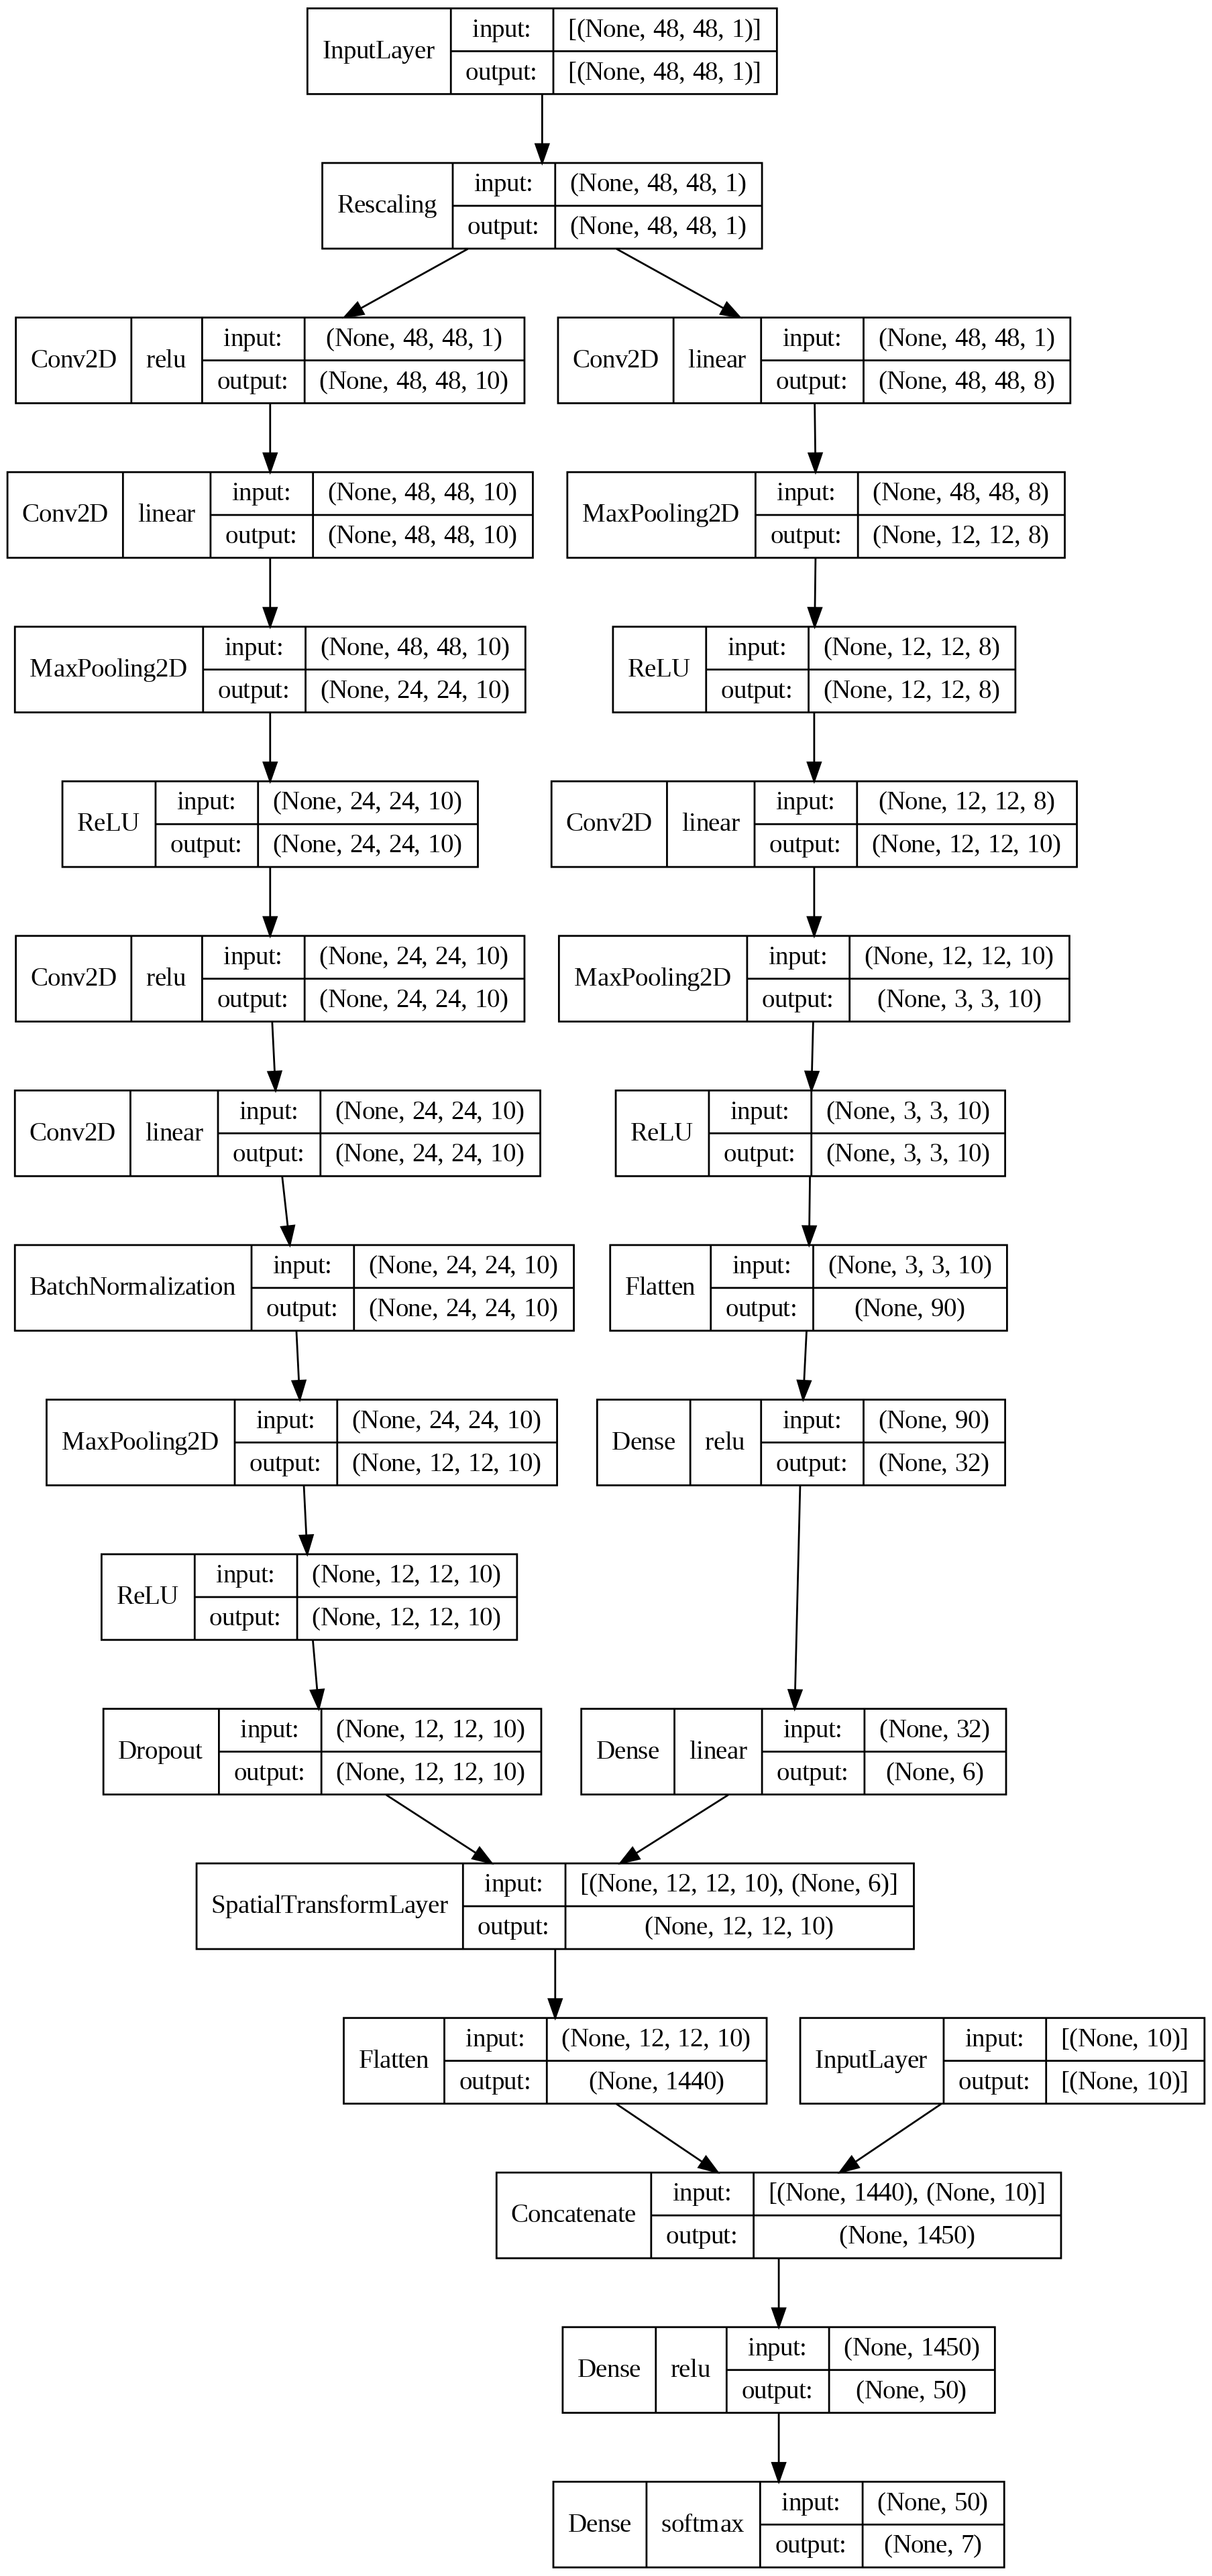

In [ ]:
tf.keras.utils.plot_model(
    modelSTN,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=200,
    show_layer_activations=True,
    show_trainable=False,)

In [ ]:
# Definimos métricas, optimizador y función de loss del modelo
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
]

# Optimizador

optimizer = optimizers.Adam(learning_rate=0.001)

# Función de loss
loss_func = tf.keras.losses.CategoricalCrossentropy()

# Número de épocas a entrenar
num_epochs = 500

# Definimos callbacks del modelo para guardar el mejor modelo y para parar el entrenamiento si no mejora

checkpoint = callbacks.ModelCheckpoint('/content/drive/MyDrive/Presentacion/Models/STN_FER.h5',
                                       monitor='val_loss',
                                       save_best_only=True,
                                       save_weights_only=True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                               fator = 0.75,
                                                               patience = 20,
                                                               min_lr = 1e-7,
                                                               verbose = 1)

early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta = 0.0001,
                                                  patience = 100,
                                                  verbose = 1,
                                                  restore_best_weights = True)

In [ ]:
modelSTN.compile(optimizer=optimizer, loss=loss_func, metrics=METRICS)

In [ ]:
# Entrenamos el modelo
history_STN = modelSTN.fit(train_ds_lbp,
                validation_data=val_ds_lbp,
                epochs=num_epochs,
                callbacks=[checkpoint, early_stopping, learning_rate_reduction])

Epoch 1/500
439/439 [==============================] - 9s 11ms/step - loss: 2.0111 - accuracy: 0.3271 - val_loss: 1.8936 - val_accuracy: 0.3432 - lr: 0.0010
Epoch 2/500
439/439 [==============================] - 4s 9ms/step - loss: 1.6809 - accuracy: 0.3888 - val_loss: 1.6697 - val_accuracy: 0.3893 - lr: 0.0010
Epoch 3/500
439/439 [==============================] - 4s 10ms/step - loss: 1.6353 - accuracy: 0.4042 - val_loss: 1.6019 - val_accuracy: 0.4312 - lr: 0.0010
Epoch 4/500
439/439 [==============================] - 4s 9ms/step - loss: 1.6080 - accuracy: 0.4179 - val_loss: 1.5464 - val_accuracy: 0.4577 - lr: 0.0010
Epoch 5/500
439/439 [==============================] - 4s 9ms/step - loss: 1.5812 - accuracy: 0.4315 - val_loss: 1.5771 - val_accuracy: 0.4389 - lr: 0.0010
Epoch 6/500
439/439 [==============================] - 4s 9ms/step - loss: 1.5562 - accuracy: 0.4426 - val_loss: 1.5453 - val_accuracy: 0.4415 - lr: 0.0010
Epoch 7/500
439/439 [==============================] - 4s 9ms/

* Al tener muchos menos parámetros esta red entrenarla durante muchas épocas no es tan costoso computaicionalmente y se realiza en mucho menos tiempo cada época, es por esto que se planeaba entrear durante 500 épocas. Sin embargo se detiene el entrenamiento en la época 406 puesto que el modelo no mejoro el loss en el set de validación en 100 épocas.

* Veamos como fue la evolución del loss en el set de entrenamiento y validación.

* Veamos también la matriz de confusión y el reporte de clasificación en el set de test.

In [ ]:
modelSTN.save('/content/drive/MyDrive/Presentacion/Models/modelSTN.keras')
modelSTN.save('/content/drive/MyDrive/Presentacion/Models/modelSTN.H5')
history_STN_df = pd.DataFrame(history_STN.history)
history_STN_df.to_csv('/content/drive/MyDrive/Presentacion/Models/historySTN.csv', index=False)

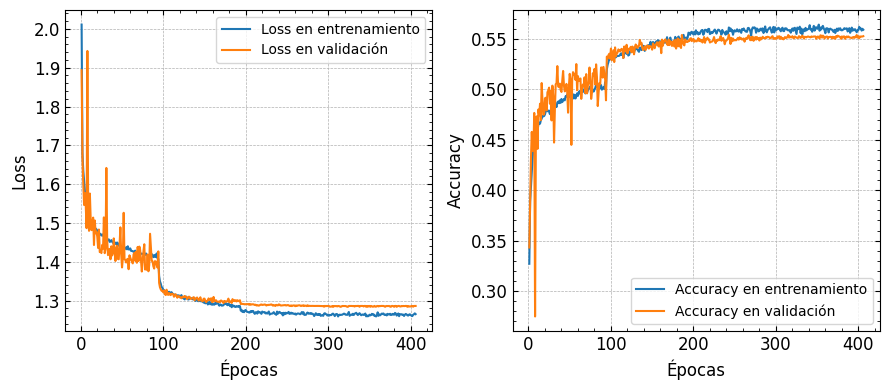

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

epocas_range = range(1, len(history_STN.history['accuracy'])+1)

ax[0].plot(epocas_range,history_STN.history['loss'], label='Loss en entrenamiento')
ax[0].plot(epocas_range,history_STN.history['val_loss'], label='Loss en validación')
ax[0].set_xlabel('Épocas', fontsize = 12)
ax[0].set_ylabel('Loss', fontsize = 12)
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_major_locator(plt.AutoLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_ticks_position('both')
ax[0].xaxis.set_ticks_position('both')
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[0].legend(fontsize=10, loc = "best")
ax[0].grid(linestyle='--', linewidth=0.5)

ax[1].plot(epocas_range,history_STN.history['accuracy'], label='Accuracy en entrenamiento')
ax[1].plot(epocas_range,history_STN.history['val_accuracy'], label='Accuracy en validación')
ax[1].set_xlabel('Épocas', fontsize = 12)
ax[1].set_ylabel('Accuracy', fontsize = 12)
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_major_locator(plt.AutoLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_ticks_position('both')
ax[1].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[1].legend(fontsize=10, loc = "best")
ax[1].grid(linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

* Nuevamente llegamos a un mínimo local en el loss y no podemos mejorar la precisión del modelo.

In [ ]:
predicts = modelSTN.predict(test_ds_lbp)

57/57 [==============================] - 0s 4ms/step


              precision    recall  f1-score   support

       Angry       0.48      0.39      0.43       491
     Disgust       1.00      0.04      0.07        55
        Fear       0.37      0.23      0.28       528
       Happy       0.74      0.83      0.78       879
         Sad       0.40      0.48      0.43       594
    Surprise       0.69      0.66      0.67       416
     Neutral       0.52      0.63      0.57       626

    accuracy                           0.56      3589
   macro avg       0.60      0.46      0.46      3589
weighted avg       0.55      0.56      0.54      3589



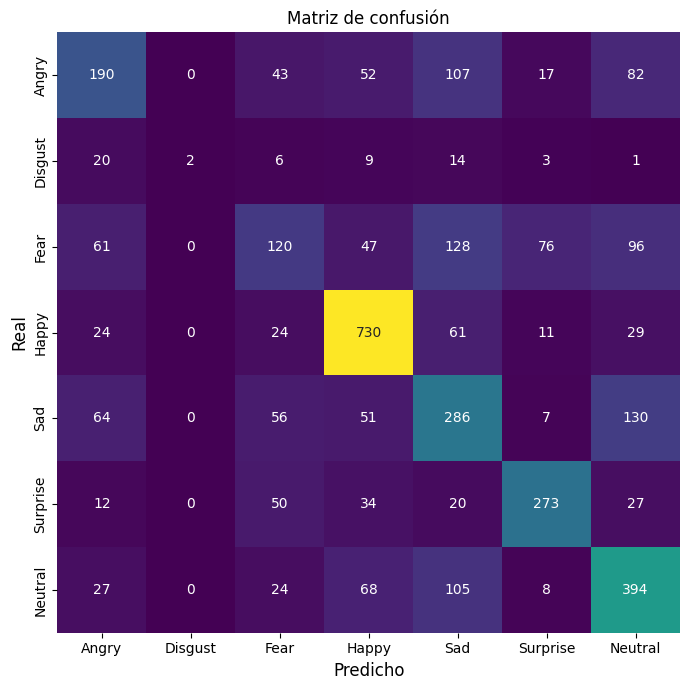

In [ ]:
y_pred = np.argmax(predicts, axis=1)
y_true = np.argmax(np.concatenate([y for _, y in test_ds], axis=0), axis = 1)

print(classification_report(y_true, y_pred, target_names=labels_emotions))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=labels_emotions, yticklabels=labels_emotions, cbar=False)
plt.xlabel('Predicho', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.title('Matriz de confusión', fontsize=12)
plt.tight_layout()
plt.show()

* El comportamiento es similar al del primer modelo, sin este mecanismo de atención, sin embargo, este modelo tiene muchos menos parámetros lo cual es bastante interesante.

## Modelo 4 - Atención espacial y de canal

* Hasta el momento solo utilizamos una especie de atención que se basaba en la transformación espacial de la imagen, ahora vamos a utilizar un mecanismo de atención que se basa en la atención espacial y de canal de los feature maps. Este mecanismo se llama CBAM (Convolutional Block Attention Module).

* Los convolutional block attention modules (CBAM) son una forma de integrar la atención espacial y de canal en una red neuronal convolucional. Estos buscan enfatizar las features significativas a traves de las dos dimensiones principales de los feature maps, es decir la altura y el ancho, y a través de los canales.

![cbam](https://imgur.com/m5T8VfG.png)

* Este módulo de atención trata a un feature map $F \in \mathbb{R}^{H \times W \times C}$ infiriendo un mapa de atención de canal 1D $M_c \in \mathbb{R}^{C}$ y un mapa de atención espacial 2D $M_s \in \mathbb{R}^{H \times W}$. El proceso se resumen en las operaciones

$$F^{\prime} = M_c(F) \otimes F$$
$$F^{\prime\prime} = M_s(F^{\prime}) \otimes F^{\prime}$$

Donde $\otimes$ es el producto elemento a elemento.

![cbam](https://imgur.com/YOO8DLo.png)

### Módulo de atención de canal
* El canal de los feature maps es crucial para la representación de las features, ya que cada canal puede capturar diferentes aspectos de la imagen. El módulo de atención espacial comprime las componentes espaciales en dos vectores de features: uno mediante Global Average Pooling y otro mediante Global Max Pooling. Estos vectores pasan por una red feedforward de dos capas densas con activación ReLU. Al final, se suman elemento a elemento y se aplica una activación sigmoide para obtener el mapa de atención de canal.

$$M_c = \sigma(MLP_{c}(GAP(F)) + MLP_{c}(GMP(F)))$$

### Módulo de atención espacial

* El módulo de atención espacial se encarga de enfatizar las partes más importantes del espacio de las características. Primero, se toma el feature map, ya pesado por el módulo de atención de canal, y se le aplican dos operaciones de pooling nuevamente, esta vez a lo largo del eje de los canales. Luego, estos dos mapas se concatenan y pasan por una red convolucional con un filtro de tamaño 7x7 y activación ReLU. Finalmente, se aplica una activación sigmoide para obtener el mapa de atención espacial.

$$M_s = \sigma(Conv_{7x7}(Concat(GAP(F^{\prime}), GMP(F^{\prime}))))$$


https://link.springer.com/chapter/10.1007/978-981-99-1642-9_43 (Emotion Recognition with Facial Attention and Objective Activation Functions) Esta red explora la utilización de funciones de activación objetivas y mecanismos de atención para la clasificación de emociones en rostros.

https://arxiv.org/abs/2105.03588 (Facial Emotion Recognition: State of the Art Performance on FER2013) Este paper utiliza una VGGNet con los hiperparámetros y técnicas de entrenamiento optimizadas para el dataset FER2013.

La idea fue mezclar estos dos papers para obtener un modelo que tenga un buen desempeño en la clasificación de emociones en rostros.

In [67]:
@keras.saving.register_keras_serializable()
class CBAMBlock(layers.Layer):
    def __init__(self, filter_num, reduction_ratio=32, kernel_size=7, **kwargs):
        super(CBAMBlock, self).__init__(**kwargs)
        self.filter_num = filter_num
        self.reduction_ratio = reduction_ratio
        self.kernel_size = kernel_size

        # Atención de canales
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.global_max_pool = layers.GlobalMaxPool2D()
        self.dense1 = layers.Dense(self.filter_num // self.reduction_ratio, activation='relu')
        self.dense2 = layers.Dense(self.filter_num)
        self.sigmoid = layers.Activation('sigmoid')
        self.reshape = layers.Reshape((1, 1, self.filter_num))
        self.multiply = layers.Multiply()

        # Atención espacial
        self.conv2d = layers.Conv2D(1, kernel_size=self.kernel_size, padding='same')
        self.spatial_sigmoid = layers.Activation('sigmoid')

    def call(self, input_tensor):
        axis = -1

        # Atención de canales
        avg_pool = self.global_avg_pool(input_tensor)
        max_pool = self.global_max_pool(input_tensor)
        avg_out = self.dense2(self.dense1(avg_pool))
        max_out = self.dense2(self.dense1(max_pool))
        channel = self.sigmoid(avg_out + max_out)
        channel = self.reshape(channel)
        channel_out = self.multiply([input_tensor, channel])

        # Atención espacial
        avg_pool2 = tf.reduce_mean(input_tensor, axis=axis, keepdims=True)
        max_pool2 = tf.reduce_max(input_tensor, axis=axis, keepdims=True)
        spatial = layers.concatenate([avg_pool2, max_pool2], axis=axis)
        spatial_out = self.spatial_sigmoid(self.conv2d(spatial))

        cbam_out = self.multiply([channel_out, spatial_out])
        return cbam_out

In [68]:
# Agregamos a un modelo VGG hecho desde 0 los bloques CBAM

input_img = layers.Input(shape = (img_height, img_width, 1), name = 'imagenes')

# Bloque 1
x = layers.Conv2D(64, (3, 3), padding='same')(input_img)
x = layers.BatchNormalization()(x)
x = tf.nn.relu(x)

x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = tf.nn.relu(x)

x = CBAMBlock(64, reduction_ratio=32)(x)

x = layers.MaxPooling2D((2, 2), strides=2)(x)

# Bloque 2
x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = tf.nn.relu(x)

x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = tf.nn.relu(x)

x = CBAMBlock(128, reduction_ratio=32)(x)

x = layers.MaxPooling2D((2, 2), strides=2)(x)

# Bloque 3
x = layers.Conv2D(256, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = tf.nn.relu(x)

x = layers.Conv2D(256, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = tf.nn.relu(x)

x = CBAMBlock(256, reduction_ratio=64)(x)

x = layers.MaxPooling2D((2, 2), strides=2)(x)


# Bloque 4
x = layers.Conv2D(512, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = tf.nn.relu(x)

x = layers.Conv2D(512, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = tf.nn.relu(x)

x = layers.MaxPooling2D((2, 2), strides=2)(x)

x = CBAMBlock(512, reduction_ratio=64)(x)

# Flatten
x = layers.Flatten()(x)

# Capas fully connected
x = layers.Dense(4096)(x)
x = tf.nn.relu(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(4096)(x)
x = tf.nn.relu(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(num_classes, activation = 'softmax')(x)

# Creamos el modelo
modelCBAM = keras.models.Model(inputs=input_img, outputs=output)

modelCBAM.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 imagenes (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_8 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 tf.nn.relu_10 (TFOpLambda)  (None, 48, 48, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_9 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                          

* Vemos que terminamos con un modelo bastante grande con 40.389.413 parámetros entrenables.

* Uno de los cambios es el método de optimización donde dejamos de utilizar Adam para utilizar SDG (Gradient descent (with momentum) optimizer) con un learning rate de 0.01 y un momentum de 0.9 y momento Nesterov.

In [50]:
# Definimos métricas, optimizador y función de loss del modelo
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
]

# Learning rate inicial
initial_learning_rate = 0.01

# Optimizador
#optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001
optimizer = optimizers.legacy.SGD(learning_rate=initial_learning_rate, momentum=0.9, decay=SGD_DECAY, nesterov=True)

# Función de loss
loss_func = tf.keras.losses.CategoricalCrossentropy()

# Definimos callbacks del modelo para guardar el mejor modelo y para parar el entrenamiento si no mejora

checkpoint = callbacks.ModelCheckpoint(r'/content/drive/MyDrive/Presentacion/Models/modelCBAM.h5',
                                       monitor='val_accuracy',
                                       save_best_only=True,
                                       save_weights_only=True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                               fator = 0.75,
                                                               patience = 5,
                                                               verbose = 1)

early_stopping = callbacks.EarlyStopping(monitor='val_accuracy',
                                                  min_delta = 0.0001,
                                                  patience = 30,
                                                  verbose = 1,
                                                  restore_best_weights = True)

In [ ]:
modelCBAM.compile(optimizer=optimizer, loss=loss_func, metrics=METRICS)

In [ ]:
# Entrenamos el modelo
historyCBAM = modelCBAM.fit(train_ds,
                validation_data=val_ds,
                epochs=100,
                callbacks=[checkpoint, learning_rate_reduction, early_stopping])

Epoch 1/100
439/439 [==============================] - 25s 48ms/step - loss: 1.7634 - accuracy: 0.2687 - val_loss: 1.8505 - val_accuracy: 0.2572 - lr: 0.0100
Epoch 2/100
439/439 [==============================] - 19s 44ms/step - loss: 1.6201 - accuracy: 0.3540 - val_loss: 1.5591 - val_accuracy: 0.3839 - lr: 0.0100
Epoch 3/100
439/439 [==============================] - 17s 39ms/step - loss: 1.4502 - accuracy: 0.4376 - val_loss: 1.6451 - val_accuracy: 0.3441 - lr: 0.0100
Epoch 4/100
439/439 [==============================] - 21s 48ms/step - loss: 1.3286 - accuracy: 0.4888 - val_loss: 1.3819 - val_accuracy: 0.4714 - lr: 0.0100
Epoch 5/100
439/439 [==============================] - 19s 43ms/step - loss: 1.2507 - accuracy: 0.5248 - val_loss: 1.2907 - val_accuracy: 0.5081 - lr: 0.0100
Epoch 6/100
439/439 [==============================] - 19s 43ms/step - loss: 1.1973 - accuracy: 0.5459 - val_loss: 1.1795 - val_accuracy: 0.5551 - lr: 0.0100
Epoch 7/100
439/439 [==============================]

* El modelo para el entrenamiento en la época 64 puesto que el loss de validación no mejoró en 20 épocas. Veamos como fue la evolución del loss y accuracy en el set de entrenamiento y validación.

In [ ]:
modelCBAM.save('/content/drive/MyDrive/Presentacion/Models/modelCBAM.keras')
modelCBAM.save('/content/drive/MyDrive/Presentacion/Models/modelCBAM.H5')

historyCBAM_df = pd.DataFrame(historyCBAM.history)
historyCBAM_df.to_csv('/content/drive/MyDrive/Presentacion/Models/historyCBAM.csv', index=False)

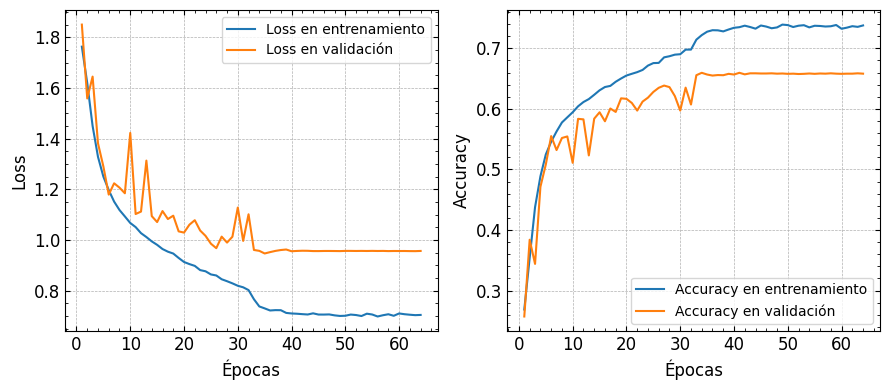

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

epocas_range = range(1, len(historyCBAM.history['accuracy'])+1)

ax[0].plot(epocas_range,historyCBAM.history['loss'], label='Loss en entrenamiento')
ax[0].plot(epocas_range,historyCBAM.history['val_loss'], label='Loss en validación')
ax[0].set_xlabel('Épocas', fontsize = 12)
ax[0].set_ylabel('Loss', fontsize = 12)
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_major_locator(plt.AutoLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_ticks_position('both')
ax[0].xaxis.set_ticks_position('both')
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[0].legend(fontsize=10, loc = "best")
ax[0].grid(linestyle='--', linewidth=0.5)

ax[1].plot(epocas_range,historyCBAM.history['accuracy'], label='Accuracy en entrenamiento')
ax[1].plot(epocas_range,historyCBAM.history['val_accuracy'], label='Accuracy en validación')
ax[1].set_xlabel('Épocas', fontsize = 12)
ax[1].set_ylabel('Accuracy', fontsize = 12)
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_major_locator(plt.AutoLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_ticks_position('both')
ax[1].tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
ax[1].legend(fontsize=10, loc = "best")
ax[1].grid(linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

* Esta vez estamos llegando casi al overfitting, pero el modelo no logra mejorar el loss ni el accuracy en el set de validación.

* Si evaluamos en el set de test vemos que obtenemos un accuracy de 0.66 lo cual es un buen resultado comparado con los anteriores modelos.

In [ ]:
loss_test, acc_test = modelCBAM.evaluate(test_ds)
print("El loss final en el conjunto de test es:", loss_test)
print("El accuracy en el conjunto de test es:", acc_test)

57/57 [==============================] - 1s 15ms/step - loss: 0.9069 - accuracy: 0.6606
El loss final en el conjunto de test es: 0.9068957567214966
El accuracy en el conjunto de test es: 0.6606296896934509


In [ ]:
predicts = modelCBAM.predict(test_ds)

57/57 [==============================] - 1s 7ms/step


* Veamos la matriz de confusión y el reporte de clasificación en el set de test.

              precision    recall  f1-score   support

       Angry       0.59      0.61      0.60       491
     Disgust       0.62      0.51      0.56        55
        Fear       0.57      0.35      0.43       528
       Happy       0.87      0.88      0.87       879
         Sad       0.50      0.56      0.53       594
    Surprise       0.77      0.76      0.77       416
     Neutral       0.59      0.70      0.64       626

    accuracy                           0.66      3589
   macro avg       0.64      0.62      0.63      3589
weighted avg       0.66      0.66      0.66      3589



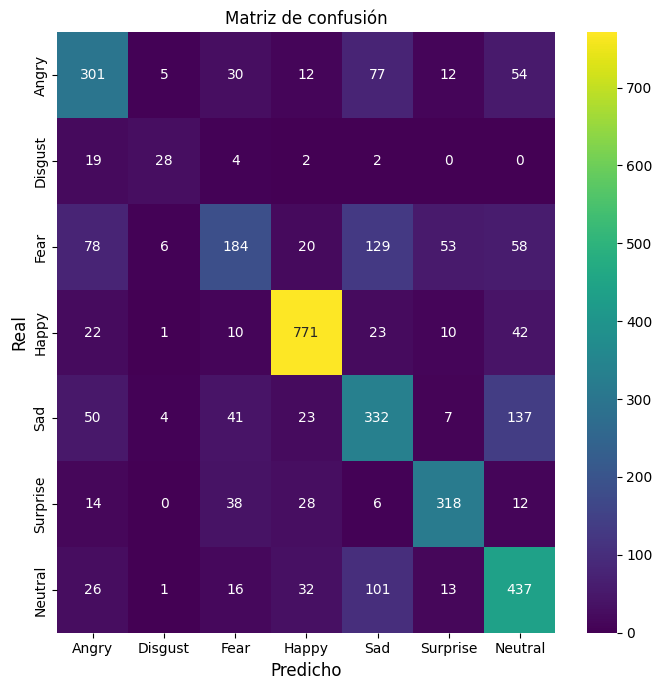

In [ ]:
y_pred = np.argmax(predicts, axis=1)
y_true = np.argmax(np.concatenate([y for _, y in test_ds], axis=0), axis = 1)

print(classification_report(y_true, y_pred, target_names=labels_emotions))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=labels_emotions, yticklabels=labels_emotions)
plt.xlabel('Predicho', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.title('Matriz de confusión', fontsize=12)
plt.tight_layout()
plt.show()

* Vemos que mejoran tanto precisión como recall de todas las clases llegando a un rendimiento moderado en las que antes se tenia un rendimiento bajo.

* Con un 66% de accuracy en este dataset estamos en el top 12 del State of the art. Podemos reentrenar este modelo con los datos de validación para ver si mejora la precisión

* La segunda parte de este trabajo consiste en utilizar el modelo para con un chatbot de manera empática y emocional. Además vamos a utilizar un modelo preentrenado LLM con prompts según el estado de ánimo detectado.

### Re entrenameinto del modelo con los datos de validación

In [69]:
modelCBAM.load_weights('/content/drive/MyDrive/Presentacion/Models/modelCBAM.h5')

In [27]:
def getData(dataframe):
    N = dataframe.shape[0]
    X = np.zeros((N, img_height, img_width, 1))
    y = np.zeros(N)
    for i in range(N):
        x = np.array(list(map(np.float32, dataframe.iloc[i]['pixels'].split()))).reshape((img_height,img_width, 1))
        yy = np.float32(dataframe.iloc[i]['emotion'])
        X[i] = x
        y[i] = yy

    y = pd.get_dummies(y)

    return X, y

In [23]:
train_total = df[np.logical_or(df['Usage'] == 'PublicTest', df['Usage'] == 'Training')]
test_total = df[df['Usage'] == 'PrivateTest']

In [28]:
X_train_total, y_train_total = getData(train_total)
X_test, y_test = getData(test_total)
y_train_total = np.asarray(y_train_total)
y_test = np.asarray(y_test)

In [47]:
X_train_total_cl, y_train_total_cl = clean_data(X_train_total, y_train_total)

In [48]:
train_total_ds = prepare_dataset(X_train_total_cl, y_train_total_cl, batch_size=64, shuffle=True, augmentation=True, training=True)
test_ds = prepare_dataset(X_test, y_test, batch_size=64, shuffle=False, augmentation=False, training=False)

In [70]:
# Definimos métricas, optimizador y función de loss del modelo
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
]

# Learning rate inicial
initial_learning_rate = 0.01

# Optimizador
#optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001
optimizer = optimizers.legacy.SGD(learning_rate=initial_learning_rate, momentum=0.9, decay=SGD_DECAY, nesterov=True)

# Función de loss
loss_func = tf.keras.losses.CategoricalCrossentropy()

# Definimos callbacks del modelo para guardar el mejor modelo y para parar el entrenamiento si no mejora

checkpoint = callbacks.ModelCheckpoint(r'/content/drive/MyDrive/Presentacion/Models/ModelCBAM2_red.h5',
                                       monitor = 'accuracy',
                                       save_best_only=True,
                                       save_weights_only=True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'accuracy',
                                                               fator = 0.75,
                                                               patience = 5,
                                                               verbose = 1)

early_stopping = callbacks.EarlyStopping(monitor = 'accuracy',
                                         min_delta = 0.0001,
                                         patience = 30,
                                         verbose = 1,
                                         restore_best_weights = True)

In [71]:
modelCBAM.compile(optimizer=optimizer, loss=loss_func, metrics=METRICS)

In [72]:
historyCBAM2 = modelCBAM.fit(train_total_ds,
                             epochs=50,
                             callbacks=[checkpoint, learning_rate_reduction, early_stopping])

Epoch 1/50
494/494 [==============================] - 24s 43ms/step - loss: 0.8953 - accuracy: 0.6634 - lr: 0.0100
Epoch 2/50
494/494 [==============================] - 21s 43ms/step - loss: 0.8843 - accuracy: 0.6685 - lr: 0.0100
Epoch 3/50
494/494 [==============================] - 21s 42ms/step - loss: 0.8710 - accuracy: 0.6724 - lr: 0.0100
Epoch 4/50
494/494 [==============================] - 21s 43ms/step - loss: 0.8530 - accuracy: 0.6793 - lr: 0.0100
Epoch 5/50
494/494 [==============================] - 22s 44ms/step - loss: 0.8382 - accuracy: 0.6851 - lr: 0.0100
Epoch 6/50
494/494 [==============================] - 21s 42ms/step - loss: 0.8221 - accuracy: 0.6924 - lr: 0.0100
Epoch 7/50
494/494 [==============================] - 21s 42ms/step - loss: 0.8111 - accuracy: 0.6948 - lr: 0.0100
Epoch 8/50
494/494 [==============================] - 22s 45ms/step - loss: 0.7992 - accuracy: 0.7008 - lr: 0.0100
Epoch 9/50
494/494 [==============================] - 21s 42ms/step - loss: 0.78

In [74]:
loss_test, acc_test = modelCBAM.evaluate(test_ds)
print("El loss final en el conjunto de test es:", loss_test)
print("El accuracy en el conjunto de test es:", acc_test)

57/57 [==============================] - 1s 8ms/step - loss: 1.2238 - accuracy: 0.6517
El loss final en el conjunto de test es: 1.2238092422485352
El accuracy en el conjunto de test es: 0.6517135500907898


In [75]:
predicts = modelCBAM.predict(test_ds)

57/57 [==============================] - 1s 7ms/step


              precision    recall  f1-score   support

       Angry       0.52      0.64      0.57       491
     Disgust       0.67      0.73      0.70        55
        Fear       0.53      0.40      0.46       528
       Happy       0.88      0.84      0.86       879
         Sad       0.48      0.54      0.51       594
    Surprise       0.81      0.73      0.76       416
     Neutral       0.65      0.66      0.65       626

    accuracy                           0.65      3589
   macro avg       0.65      0.65      0.64      3589
weighted avg       0.66      0.65      0.65      3589



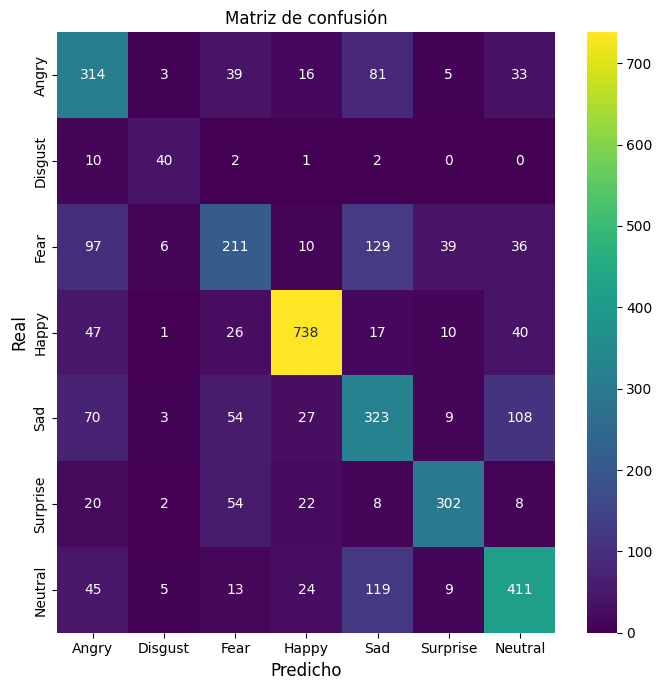

In [76]:
y_pred = np.argmax(predicts, axis=1)
y_true = np.argmax(np.concatenate([y for _, y in test_ds], axis=0), axis = 1)

print(classification_report(y_true, y_pred, target_names=labels_emotions))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=labels_emotions, yticklabels=labels_emotions)
plt.xlabel('Predicho', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.title('Matriz de confusión', fontsize=12)
plt.tight_layout()
plt.show()

* Seguramente estemos por llegar al overfitting, no parece mejorar el modelo

### Entrenamiento con pocas clases

* Quizas para la segunda parte nos conviene tener un modelo con menos emociones para tener una mejor precisión, por lo tanto vamos a quedarnos con las principales que son: Enojado, Feliz, Triste y Neutral. Vamos a hacer trampa y usar todos los datos de una única vez para tener un modelo lo mejor entrenado posible.

In [89]:
labels_emotions_reduced = ['Angry', 'Happy', 'Sad', 'Neutral']
num_classes_reduced = len(labels_emotions_reduced)

In [90]:
df_red = df[~df['emotion'].isin([1, 2, 5])]

train_red = df_red[np.logical_or(df_red['Usage'] == 'PublicTest', df_red['Usage'] == 'Training')]
test_red = df_red[df_red['Usage'] == 'PrivateTest']

In [91]:
X_train_red, y_train_red = getData(train_red)
X_test_red, y_test_red = getData(test_red)
y_train_red = np.asarray(y_train_red)
y_test_red = np.asarray(y_test_red)

In [92]:
X_train_cl, y_train_cl = clean_data(X_train_red, y_train_red)

In [93]:
train_ds_red = prepare_dataset(X_train_cl, y_train_cl, batch_size = 64, shuffle = True, augmentation = True, training = True)
test_ds_red = prepare_dataset(X_test_red, y_test_red, batch_size = 64, shuffle = False, augmentation = False, training = False)

In [94]:
# Agregamos a un modelo VGG hecho los bloques CBAM

input_img = layers.Input(shape = (img_height, img_width, 1), name = 'imagenes')

# Bloque 1
x = layers.Conv2D(64, (3, 3), padding='same')(input_img)
x = layers.BatchNormalization()(x)
x = tf.nn.relu(x)

x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = tf.nn.relu(x)

x = CBAMBlock(64, reduction_ratio=32)(x)

x = layers.MaxPooling2D((2, 2), strides=2)(x)

# Bloque 2
x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = tf.nn.relu(x)

x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = tf.nn.relu(x)

x = CBAMBlock(128, reduction_ratio=32)(x)

x = layers.MaxPooling2D((2, 2), strides=2)(x)

# Bloque 3
x = layers.Conv2D(256, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = tf.nn.relu(x)

x = layers.Conv2D(256, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = tf.nn.relu(x)

x = CBAMBlock(256, reduction_ratio=64)(x)

x = layers.MaxPooling2D((2, 2), strides=2)(x)


# Bloque 4
x = layers.Conv2D(512, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = tf.nn.relu(x)

x = layers.Conv2D(512, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = tf.nn.relu(x)

x = layers.MaxPooling2D((2, 2), strides=2)(x)

x = CBAMBlock(512, reduction_ratio=64)(x)

# Flatten
x = layers.Flatten()(x)

# Capas fully connected
x = layers.Dense(4096)(x)
x = tf.nn.relu(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(4096)(x)
x = tf.nn.relu(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(num_classes_reduced, activation = 'softmax')(x)

# Creamos el modelo
modelCBAM_red = keras.models.Model(inputs=input_img, outputs=output)

modelCBAM_red.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 imagenes (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_24 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 tf.nn.relu_30 (TFOpLambda)  (None, 48, 48, 64)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_25 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                         

In [95]:
# Definimos métricas, optimizador y función de loss del modelo
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
]

# Learning rate inicial
initial_learning_rate = 0.01

# Optimizador
#optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001
optimizer = optimizers.legacy.SGD(learning_rate=initial_learning_rate, momentum=0.9, decay=SGD_DECAY, nesterov=True)

# Función de loss
loss_func = tf.keras.losses.CategoricalCrossentropy()

# Definimos callbacks del modelo para guardar el mejor modelo y para parar el entrenamiento si no mejora

checkpoint = callbacks.ModelCheckpoint('/content/drive/MyDrive/Presentacion/Models/ModelCBAM_red.h5',
                                       monitor = 'val_accuracy',
                                       save_best_only=True,
                                       save_weights_only=True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                               fator = 0.75,
                                                               patience = 5,
                                                               verbose = 1)

early_stopping = callbacks.EarlyStopping(monitor = 'val_accuracy',
                                         min_delta = 0.0001,
                                         patience = 30,
                                         verbose = 1,
                                         restore_best_weights = True)

In [96]:
modelCBAM_red.compile(optimizer=optimizer, loss=loss_func, metrics=METRICS)

In [98]:
historyCBAM_red = modelCBAM_red.fit(train_ds_red,
                                validation_data=test_ds_red,
                                epochs=100,
                                callbacks=[checkpoint, learning_rate_reduction, early_stopping])

Epoch 1/100
362/362 [==============================] - 20s 49ms/step - loss: 1.3428 - accuracy: 0.3519 - val_loss: 1.4114 - val_accuracy: 0.2417 - lr: 0.0100
Epoch 2/100
362/362 [==============================] - 15s 41ms/step - loss: 1.2185 - accuracy: 0.4444 - val_loss: 1.4747 - val_accuracy: 0.3089 - lr: 0.0100
Epoch 3/100
362/362 [==============================] - 17s 46ms/step - loss: 1.1007 - accuracy: 0.5083 - val_loss: 1.2765 - val_accuracy: 0.4089 - lr: 0.0100
Epoch 4/100
362/362 [==============================] - 15s 40ms/step - loss: 1.0101 - accuracy: 0.5638 - val_loss: 1.0347 - val_accuracy: 0.5517 - lr: 0.0100
Epoch 5/100
362/362 [==============================] - 16s 45ms/step - loss: 0.9447 - accuracy: 0.5980 - val_loss: 0.9692 - val_accuracy: 0.6004 - lr: 0.0100
Epoch 6/100
362/362 [==============================] - 14s 39ms/step - loss: 0.8990 - accuracy: 0.6236 - val_loss: 1.0183 - val_accuracy: 0.5568 - lr: 0.0100
Epoch 7/100
362/362 [==============================]

In [99]:
modelCBAM_red.save('/content/drive/MyDrive/Presentacion/Models/modelCBAM_red.keras')
modelCBAM_red.save('/content/drive/MyDrive/Presentacion/Models/modelCBAM_red.H5')

In [100]:
loss_test, acc_test = modelCBAM_red.evaluate(test_ds_red)
print("El loss final en el conjunto de test es:", loss_test)
print("El accuracy en el conjunto de test es:", acc_test)

41/41 [==============================] - 0s 8ms/step - loss: 0.6584 - accuracy: 0.7386
El loss final en el conjunto de test es: 0.6583894491195679
El accuracy en el conjunto de test es: 0.738610029220581


In [101]:
predicts = modelCBAM_red.predict(test_ds_red)

41/41 [==============================] - 1s 7ms/step


              precision    recall  f1-score   support

       Angry       0.71      0.66      0.69       491
       Happy       0.91      0.91      0.91       879
         Sad       0.60      0.60      0.60       594
     Neutral       0.65      0.70      0.67       626

    accuracy                           0.74      2590
   macro avg       0.72      0.72      0.72      2590
weighted avg       0.74      0.74      0.74      2590



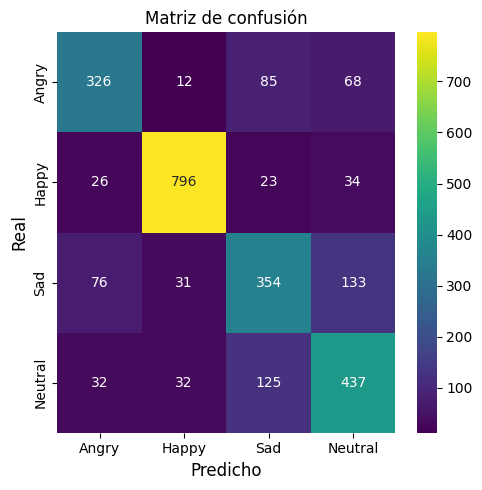

In [102]:
y_pred = np.argmax(predicts, axis=1)
y_true = np.argmax(np.concatenate([y for _, y in test_ds_red], axis=0), axis = 1)

print(classification_report(y_true, y_pred, target_names=labels_emotions_reduced))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=labels_emotions_reduced, yticklabels=labels_emotions_reduced)
plt.xlabel('Predicho', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.title('Matriz de confusión', fontsize=12)
plt.tight_layout()
plt.show()

# Conclusiones:

* No logramos reproducir los resultados del estado del arte en este dataset, sin embargo logramos un desempeño aceptable en la clasificación de emociones en imágenes de rostros. Utilizamos técnicas avanzadas como transfer learning y mecanismos de atención para mejorar el desempeño de la red neuronal convolucional. Sin embargo, el desempeño de la red sigue siendo bajo comparado con otros datasets de clasificación de imágenes.

* En la segunda parte del trabajo utilizamos el modelo entrenado para clasificar emociones en imágenes de rostros para hacer un chatbot empático y emocional. Utilizamos un modelo preentrenado LLM con prompts según el estado de ánimo detectado. El chatbot es capaz de detectar el estado de ánimo del usuario y responder de manera empática y emocional.

* Posibles mejoras para este trabajo incluirian utilizar un ensamble de modelos para ver si esto mejora el desempeño de las predicciones. Otra mejora sería explorar más el espacio de hiperparámetros para ver si podemos mejorar el desempeño de la red neuronal convolucional. También explorar el uso de otras arquitecturas que mezclen machine learning clásico con deep learning, como una red neuronal convolucional con un clasificador SVM en la salida de la red que es lo que se utilizaba con las features hechas ''a mano'' con LBP y HOG para este tipo de tareas.